Load all the packages :

In [1]:
import mdfreader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import os
import warnings
from datetime import datetime, timedelta
import pytz
from asammdf import MDF
import re
from scipy.interpolate import interp1d
import matplotlib.gridspec as gridspec
import itertools
import ipywidgets as widgets
from IPython.display import display, clear_output
from bs4 import BeautifulSoup

ldf is not supported


Required Files Input :

In [2]:
mdf_file_path = r"C:\Users\AFO3KOR\Downloads\592 latest\592_Absent_Invld_Fordbn.mdf"
mf4_file_path = r"C:\Users\AFO3KOR\Downloads\592 latest\592_Absent_Invld_Fordn.dat"
asc_file_path = r"C:\Users\AFO3KOR\Downloads\592 latest\592_Absent_Invld_Fordbn.asc"
dsm_excel_path = r"C:\Users\AFO3KOR\Desktop\CAN TOOL\required_docs\STLA_eCC21E_eSCW2_DTC_Matrix_V4.6.xlsm" 
disable_mask_list_path = r"C:\Users\AFO3KOR\Desktop\CAN TOOL\required_docs\disbl_mask_list_63C_CAN.xlsx"  
CAN_Matrix_path = r"C:\Users\AFO3KOR\Desktop\CAN TOOL\required_docs\eSEARx_300_400_HSN3_HSN1_HSN4_VCU_V3.6_V4.xlsx"
inhibit_overview_path = r"C:\Users\AFO3KOR\Desktop\CAN TOOL\required_docs\c6_8_cal_fid.xls"  
gateway_sheet = r"C:\Users\AFO3KOR\Desktop\CAN TOOL\required_docs\01302_23_00667_Gateway Frame Signal Synthesis v7.0 1.xlsx"

print("All the required files are loaded properly")

All the required files are loaded properly


Load the Sheets of the CAN_Matrix :

In [3]:
def load_signals_from_excel(CAN_Matrix_path):
    """Loads Excel data once to avoid repeated file access."""
    try:
        tx_df = pd.read_excel(CAN_Matrix_path, sheet_name='VCU_TX_SIGNALS')
        rx_df = pd.read_excel(CAN_Matrix_path, sheet_name='VCU_RX_SIGNALS')
    except Exception as e:
        print(f"Failed to load sheets: {str(e)}")
        return None, None
    return tx_df, rx_df




Calculating time_shift from .mf4 file and .asc file :

In [4]:
def extract_date_and_time_of_mf4(file_path):
    data = mdfreader.Mdf(file_path)

    if hasattr(data, 'fileMetadata'):
        metadata = str(data.fileMetadata)

        # Match date and time using regex
        date_match = re.search(r"Date:\s*([\d/]+)", metadata)
        time_match = re.search(r"Time:\s*([\d:]+\s*[APM]*)", metadata)

        if date_match and time_match:
            datetime_str = f"{date_match.group(1)} {time_match.group(1)}"
            try:
                dt = datetime.strptime(datetime_str, "%m/%d/%Y %I:%M:%S %p")
                return dt.strftime("%m/%d/%Y"), dt.strftime("%I:%M:%S.%f %p")
            except ValueError:
                print(f"Error parsing date and time: {datetime_str}")
                return None, None
    return None, None

def extract_date_time_of_asc(file_path):
    try:
        with open(file_path, 'r') as file:
            first_line = file.readline().strip()

            if "date" in first_line:
                date_time_str = first_line.split("date ")[1]
                dt = datetime.strptime(date_time_str, '%a %b %d %I:%M:%S.%f %p %Y')
                return dt.strftime("%m/%d/%Y"), dt.strftime("%I:%M:%S.%f %p")

    except Exception as e:
        print(f"Error reading the file: {e}")

    return None, None

def calculate_time_difference_between_mf4_and_asc(mf4_file, asc_file):
    # Extract dates and times from both files
    mf4_date, mf4_time = extract_date_and_time_of_mf4(mf4_file)
    asc_date, asc_time = extract_date_time_of_asc(asc_file)

    if mf4_date != asc_date:
        print("Dates do not match. Synchronization aborted.")
        return None, None
    
    # Convert time strings to datetime
    mf4_datetime = datetime.strptime(f"{mf4_date} {mf4_time}", "%m/%d/%Y %I:%M:%S.%f %p")
    asc_datetime = datetime.strptime(f"{asc_date} {asc_time}", "%m/%d/%Y %I:%M:%S.%f %p")
    
    # Compute time difference in seconds
    time_shift = int((mf4_datetime - asc_datetime).total_seconds())

    return time_shift

# Example usage
time_shift = calculate_time_difference_between_mf4_and_asc(mf4_file_path, asc_file_path)



In [5]:
def process_all_signals_mdf(mdf_file_path, time_shift):
    mdf_file = mdfreader.Mdf(mdf_file_path)
    all_signals = list(mdf_file.keys())
    synchronized_signals_mdf = []

    for sig in all_signals:
        signal_data = np.array(mdf_file.get_channel_data(sig))
        master_channel = mdf_file.get_channel_master(sig)
        timestamps = np.array(mdf_file.get_channel_data(master_channel))

        if len(signal_data) == 0:
            continue  # Skip if no data is found

        # Shift timestamps dynamically
        valid_indices = np.where(timestamps >= time_shift)[0]
        if len(valid_indices) == 0:
            continue  # Skip storing this signal if no valid timestamps
        
        timestamps = timestamps[valid_indices]
        signal_data = signal_data[valid_indices]
        
        # Calculate periodicity after shifting
        if len(timestamps) > 1:
            periodicity = np.median(np.diff(timestamps))  # Estimate periodicity
        else:
            continue  # Skip if not enough points to determine periodicity
        
        # Generate uniform timestamps based on periodicity
        start_time = timestamps[0]
        end_time = timestamps[-1]
        uniform_timestamps = np.arange(start_time, end_time, periodicity)
        
        # Interpolate missing data
        interpolation_function = interp1d(timestamps, signal_data, kind='linear', fill_value='extrapolate')
        interpolated_data = interpolation_function(uniform_timestamps)
        
        synchronized_signals_mdf.append({
            'dbc_signal': sig,
            'asw_signal': None,  
            'dbc_data': interpolated_data,
            'asw_data': None,
            'dbc_timestamps': uniform_timestamps,
            'asw_timestamps': None
        })

    return synchronized_signals_mdf  # Return the updated list
synchronized_signals_mdf = process_all_signals_mdf(mdf_file_path, time_shift)

Resampling the signals of the frame on based of periodicity :

In [6]:
def get_signal_periodicity(CAN_Matrix, signal_name):
    """ Extract periodicity for a given signal from the CAN Matrix Excel sheet. """
    if CAN_Matrix is not None and 'Signal Name' in CAN_Matrix.columns and 'Periodicity' in CAN_Matrix.columns:
        signal_row = CAN_Matrix[CAN_Matrix['Signal Name'] == signal_name]
        if not signal_row.empty:
            periodicity_ms = signal_row['Periodicity'].iloc[0]  # Extract periodicity in milliseconds
            return periodicity_ms / 1000 if pd.notna(periodicity_ms) else None  # Convert to seconds
    return None

def process_and_resample_signal(file_path, signal_name, CAN_Matrix_path, synchronized_signals_mdf,round_raster=True, raster_precision=3):
    
    # Load the CAN Matrix
    tx_df , rx_df = load_signals_from_excel(CAN_Matrix_path)
    CAN_Matrix = pd.concat([tx_df, rx_df], ignore_index=True)
    if CAN_Matrix is None:
        return None, None

    # Extract periodicity from the CAN Matrix
    periodicity = get_signal_periodicity(CAN_Matrix, signal_name)
    
    try:
        # Load the MDF file and retrieve signal data
        mdf_obj = mdfreader.Mdf(file_path)
        signal_data = mdf_obj.get_channel_data(signal_name)

        if signal_data is None or len(signal_data) == 0:
            print(f"Error: No data found for signal '{signal_name}' in {file_path}.")
            return None, None

        # Retrieve timestamps for the signal
        master_channel = mdf_obj.get_channel_master(signal_name)
        timestamps = mdf_obj.get_channel_data(master_channel)

        if timestamps is None or len(timestamps) == 0:
            print(f"Error: No timestamp data found for signal '{signal_name}' in {file_path}.")
            return None, None

        # Process DBC Signal (Interpolate Missing Data)
        if file_path.endswith('.mdf'):
            for entry in synchronized_signals_mdf:
                if entry.get("dbc_signal") == signal_name:
                    signal_data = entry.get("dbc_data")
                    timestamps = entry.get("dbc_timestamps")

                    if periodicity is not None:
                        # Generate uniform timestamps using periodicity
                        uniform_timestamps = np.arange(timestamps[0], timestamps[-1], periodicity)
                        # Interpolate missing DBC data
                        resampled_signal_data = np.interp(uniform_timestamps, timestamps, signal_data)
                        resample_timestamps = uniform_timestamps
                    else:
                        resample_timestamps = timestamps
                        resampled_signal_data = signal_data

        # Process ASW Signal (Use Raster Directly)
        elif file_path.endswith('.dat'):
            asw_raster_ms = None
            try:
                asw_raster_ms = mdf_obj.get_channel_master(signal_name).Raster
            except AttributeError:
                if len(timestamps) > 1:
                    asw_raster_ms = np.mean(np.diff(timestamps))  # Approximate raster

            if asw_raster_ms is not None:
                asw_raster_ms = round(asw_raster_ms, raster_precision) if round_raster else asw_raster_ms

            # Use ASW timestamps based on raster
            if asw_raster_ms is not None:
                resample_timestamps = np.arange(timestamps[0], timestamps[-1], asw_raster_ms)
                resampled_signal_data = np.interp(resample_timestamps, timestamps, signal_data)
            else:
                resample_timestamps = timestamps
                resampled_signal_data = signal_data

        else:
            print("Error: The signal name does not match any known DBC or ASW signal.")
            return None, None

        # Round the resampled signal data to the nearest integer if it's not already integer type
        if not np.issubdtype(resampled_signal_data.dtype, np.integer):
            resampled_signal_data = np.round(resampled_signal_data + 0.00001).astype(int)

        return resample_timestamps, resampled_signal_data

    except Exception as e:
        print(f"Failed to process signal '{signal_name}': {str(e)}")
        return None, None



Calculating Offset on User given sample signals :

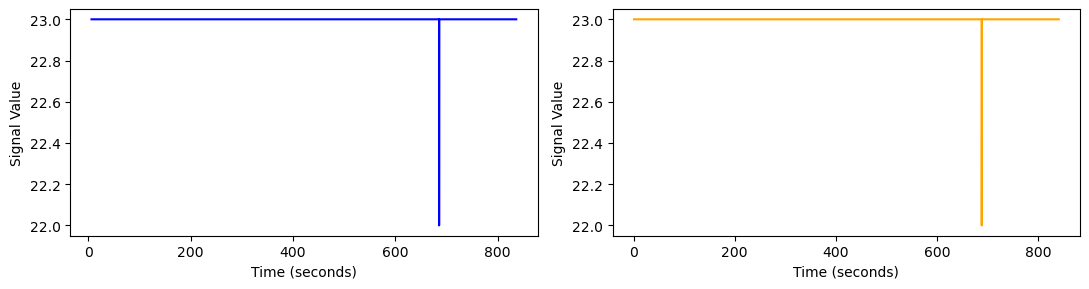


DBC State Changes:
State Change: falling, Timestamp: 685.640, Time Difference to Next: 0.030 seconds

ASW State Changes:
State Change: falling, Timestamp: 688.220, Time Difference to Next: 0.020 seconds

Two state changes matched! Offset: 2.580 seconds


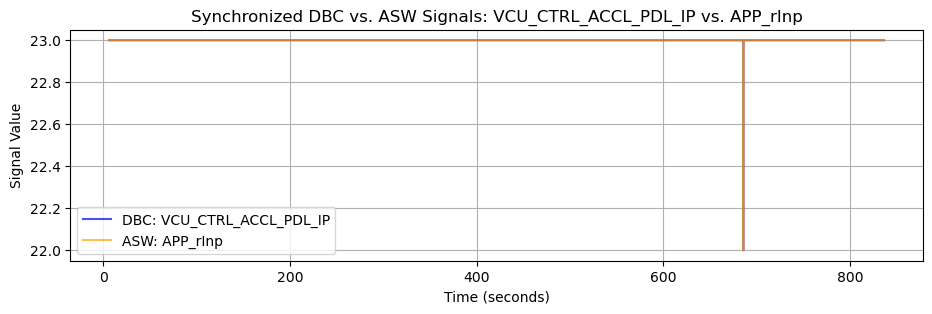

In [7]:
def find_corresponding_signal(signal_name, CAN_Matrix):
    
    # Check if the input signal matches a DBC signal (in "Signal Name" column)
    dbc_match = CAN_Matrix[CAN_Matrix['Signal Name'] == signal_name]
    if not dbc_match.empty:
        corresponding_signal = dbc_match['ASW interface'].values[0]
        return corresponding_signal, 'DBC'
    
    # Check if the input signal matches an ASW signal (in "ASW Interface" column)
    asw_match = CAN_Matrix[CAN_Matrix['ASW interface'] == signal_name]
    if not asw_match.empty:
        corresponding_signal = asw_match['Signal Name'].values[0]
        return corresponding_signal, 'ASW'
    
    # If no match is found
    print("Error: Signal not found in the CAN matrix.")
    return None, None

def find_state_changes(signal_data, timestamps):
    changes = []
    
    # Iterate through the signal data to detect state changes
    for i in range(1, len(signal_data)):
        if signal_data[i] != signal_data[i - 1]:
            # Capture the state change type and the timestamp
            change_type = 'rising' if signal_data[i] > signal_data[i - 1] else 'falling'
            changes.append((change_type, timestamps[i]))
    
    return changes

def calculate_offset_from_state_changes(dbc_timestamps, dbc_data, asw_timestamps, asw_data):
    tolerance = 0.1  # Tolerance value of 0.1 seconds

    # Find state changes for both DBC and ASW signals
    dbc_changes = find_state_changes(dbc_data, dbc_timestamps)
    asw_changes = find_state_changes(asw_data, asw_timestamps)

    print("\nDBC State Changes:")
    for i in range(len(dbc_changes) - 1):
        change_type, timestamp = dbc_changes[i]
        next_timestamp = dbc_changes[i + 1][1]
        time_diff = next_timestamp - timestamp
        print(f"State Change: {change_type}, Timestamp: {timestamp:.3f}, Time Difference to Next: {time_diff:.3f} seconds")

    print("\nASW State Changes:")
    for i in range(len(asw_changes) - 1):
        change_type, timestamp = asw_changes[i]
        next_timestamp = asw_changes[i + 1][1]
        time_diff = next_timestamp - timestamp
        print(f"State Change: {change_type}, Timestamp: {timestamp:.3f}, Time Difference to Next: {time_diff:.3f} seconds")

    # Case: Only one state change in both signals
    if len(dbc_changes) == 1 and len(asw_changes) == 1:
        dbc_type, dbc_time = dbc_changes[0]
        asw_type, asw_time = asw_changes[0]

        if dbc_type == asw_type:
            offset = asw_time - dbc_time
            print(f"\nSingle state change match found! Offset: {offset:.3f} seconds")
            return offset

    # Case: Two state changes in both signals
    if len(dbc_changes) == 2 and len(asw_changes) == 2:
        dbc_types = [change[0] for change in dbc_changes]
        asw_types = [change[0] for change in asw_changes]
        dbc_time_diffs = dbc_changes[1][1] - dbc_changes[0][1]
        asw_time_diffs = asw_changes[1][1] - asw_changes[0][1]

        if dbc_types == asw_types and abs(dbc_time_diffs - asw_time_diffs) <= tolerance:
            offset = asw_changes[0][1] - dbc_changes[0][1]
            print(f"\nTwo state changes matched! Offset: {offset:.3f} seconds")
            return offset

    # Case: General triplet matching (three or more state changes)
    if len(dbc_changes) >= 3 and len(asw_changes) >= 3:
        for i in range(len(dbc_changes) - 2):
            dbc_triplet = dbc_changes[i:i+3]
            dbc_types = [change[0] for change in dbc_triplet]
            dbc_time_diffs = np.diff([change[1] for change in dbc_triplet])

            print(f"\nConsidering DBC Triplet at index {i}: {dbc_types}")

            for j in range(len(asw_changes) - 2):
                asw_triplet = asw_changes[j:j+3]
                asw_types = [change[0] for change in asw_triplet]
                asw_time_diffs = np.diff([change[1] for change in asw_triplet])

                if dbc_types == asw_types and np.allclose(dbc_time_diffs, asw_time_diffs, atol=tolerance):
                    offset = asw_triplet[0][1] - dbc_triplet[0][1]
                    print(f"\nTriplet match found! Offset: {offset:.3f} seconds")
                    return offset

    print("\nNo matching state change pattern found between DBC and ASW signals.")
    return None


def adjust_signals_with_offset(dbc_data, asw_data, dbc_timestamps, asw_timestamps, offset):

    
    # Shift only the ASW signal
    asw_timestamps_shifted = asw_timestamps - offset  # Shift ASW timestamps backward or forward based on offset
    
    # Determine the common overlapping time range
    start_time = max(dbc_timestamps[0], asw_timestamps_shifted[0])
    end_time = min(dbc_timestamps[-1], asw_timestamps_shifted[-1])
    
    # Get indices for the overlapping range
    dbc_indices = np.where((dbc_timestamps >= start_time) & (dbc_timestamps <= end_time))[0]
    asw_indices = np.where((asw_timestamps_shifted >= start_time) & (asw_timestamps_shifted <= end_time))[0]
    
    # Trim signals to the overlapping range
    dbc_data = dbc_data[dbc_indices]
    dbc_timestamps = dbc_timestamps[dbc_indices]  # DBC timestamps remain unchanged
    asw_data = asw_data[asw_indices]
    asw_timestamps = asw_timestamps_shifted[asw_indices]
    
    return dbc_data, asw_data, dbc_timestamps, asw_timestamps

# Plot Individual Signals
def plot_individual_signals(dbc_data, asw_data, dbc_timestamps, asw_timestamps):
    plt.figure(figsize=(11, 3))
    plt.subplot(1, 2, 1)
    plt.plot(dbc_timestamps, dbc_data, color='blue')
    plt.xlabel("Time (seconds)")
    plt.ylabel("Signal Value")
 
    plt.subplot(1, 2, 2)
    plt.plot(asw_timestamps, asw_data, color='orange')
    plt.xlabel("Time (seconds)")
    plt.ylabel("Signal Value")
    plt.tight_layout()
    plt.show()
 
# Plot Synchronized Signals
def plot_synchronized_signals(dbc_data, asw_data, dbc_timestamps, asw_timestamps, dbc_name, asw_name):
    # Determine the start and end times for both signals
    start_time = max(dbc_timestamps[0], asw_timestamps[0])
    end_time = min(dbc_timestamps[-1], asw_timestamps[-1])

    # Create masks to select only the overlapping part
    dbc_mask = (dbc_timestamps >= start_time) & (dbc_timestamps <= end_time)
    asw_mask = (asw_timestamps >= start_time) & (asw_timestamps <= end_time)

    # Filter data for overlapping timestamps
    dbc_data_trimmed = dbc_data[dbc_mask]
    asw_data_trimmed = asw_data[asw_mask]
    dbc_timestamps_trimmed = dbc_timestamps[dbc_mask]
    asw_timestamps_trimmed = asw_timestamps[asw_mask]

    # Plotting the synchronized signals
    plt.figure(figsize=(11, 3))
    plt.plot(dbc_timestamps_trimmed, dbc_data_trimmed, label=f"DBC: {dbc_name}", color='blue', alpha=0.7)
    plt.plot(asw_timestamps_trimmed, asw_data_trimmed, label=f"ASW: {asw_name}", color='orange', alpha=0.7)
    plt.title(f"Synchronized DBC vs. ASW Signals: {dbc_name} vs. {asw_name}")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Signal Value")
    plt.legend()
    plt.grid()
    plt.show()
# Find the First Non-Zero Timestamp
def find_first_nonzero_timestamp(timestamps, data):
    for i, val in enumerate(data):
        if val != 0:
            return timestamps[i]
    return None
 
# Adjust Signals by Aligning Non-Zero Timestamps
def adjust_signals(dbc_data, asw_data, dbc_timestamps, asw_timestamps, dbc_length, asw_length):
    if dbc_data is not None and asw_data is not None:
        # Determine which signal is longer
        if dbc_length > asw_length:
            longest_signal, shortest_signal = dbc_data, asw_data
            longest_timestamps, shortest_timestamps = dbc_timestamps, asw_timestamps
            longest_length = dbc_length
            shortest_length = asw_length
        else:
            longest_signal, shortest_signal = asw_data, dbc_data
            longest_timestamps, shortest_timestamps = asw_timestamps, dbc_timestamps
            longest_length = asw_length
            shortest_length = dbc_length
 
        # Find the first non-zero values in both signals
        delta1 = np.where(longest_timestamps == find_first_nonzero_timestamp(longest_timestamps, longest_signal))[0][0]
        delta2 = np.where(shortest_timestamps == find_first_nonzero_timestamp(shortest_timestamps, shortest_signal))[0][0]

        
        offset = longest_timestamps[delta1] - shortest_timestamps[delta2]
        print(f"Calculated Offset from Timestamp Alignment: {offset} seconds")
        # Shift the longer signal's timestamps by the offset
        shifted_longest_timestamps = longest_timestamps - offset
 
        # Determine the start and end time for both signals after the shift
        start_time = max(shifted_longest_timestamps[0], shortest_timestamps[0])
        end_time = min(shifted_longest_timestamps[-1], shortest_timestamps[-1])
 
        # Trim both signals to the common time range
        mask_longest = (shifted_longest_timestamps >= start_time) & (shifted_longest_timestamps <= end_time)
        mask_shortest = (shortest_timestamps >= start_time) & (shortest_timestamps <= end_time)
 
        # Apply the masks to trim the signals
        longest_signal_trimmed = longest_signal[mask_longest]
        shortest_signal_trimmed = shortest_signal[mask_shortest]
        shifted_longest_timestamps_trimmed = shifted_longest_timestamps[mask_longest]
        shortest_timestamps_trimmed = shortest_timestamps[mask_shortest]
 
        # Ensure both signals are trimmed to the same length
        min_len = min(len(longest_signal_trimmed), len(shortest_signal_trimmed))
        longest_signal_trimmed = longest_signal_trimmed[:min_len]
        shortest_signal_trimmed = shortest_signal_trimmed[:min_len]
        shifted_longest_timestamps_trimmed = shifted_longest_timestamps_trimmed[:min_len]
        shortest_timestamps_trimmed = shortest_timestamps_trimmed[:min_len]
 
        return longest_signal_trimmed, shortest_signal_trimmed, shifted_longest_timestamps_trimmed, shortest_timestamps_trimmed, offset
 
    else:
        print("Error: One or both signals are None.")
        return None, None, None, None,None
 
 
# Main Comparison and Alignment Logic
def calculate_offset_for_synchronization(mdf_file_path, mf4_file_path):
    tx_df , rx_df = load_signals_from_excel(CAN_Matrix_path)
    CAN_Matrix = pd.concat([tx_df, rx_df], ignore_index=True)
    # Ask user for the signal name
    input_signal = input("Enter the signal name (either DBC or ASW): ").strip()

    # Find the corresponding signal using the CAN matrix
    corresponding_signal, signal_type = find_corresponding_signal(input_signal, CAN_Matrix)
    if not corresponding_signal:
        print("Error: Corresponding signal not found in the CAN matrix.")
        return None

    # Set DBC and ASW signal names
    dbc_signal = input_signal if signal_type == 'DBC' else corresponding_signal
    asw_signal = corresponding_signal if signal_type == 'DBC' else input_signal
    
    # Process and resample signals
    dbc_timestamps, dbc_data = process_and_resample_signal(mdf_file_path, dbc_signal, CAN_Matrix_path,synchronized_signals_mdf)
    asw_timestamps, asw_data = process_and_resample_signal(mf4_file_path, asw_signal, CAN_Matrix_path,synchronized_signals_mdf)
    
    # Check for errors in signal processing
    if dbc_data is None or asw_data is None:
        print("Error in processing the signals.")
        return None
    
    plot_individual_signals(dbc_data, asw_data, dbc_timestamps, asw_timestamps)
    # Continue synchronization (common label logic remains unchanged)
    offset = None
    if dbc_data[0] == 0 and asw_data[0] == 0:
        dbc_length = len(dbc_data)
        asw_length = len(asw_data)
        dbc_data, asw_data, dbc_timestamps, asw_timestamps, offset = adjust_signals(
            dbc_data, asw_data, dbc_timestamps, asw_timestamps, dbc_length, asw_length
        )
    else:
        offset = calculate_offset_from_state_changes(dbc_timestamps, dbc_data, asw_timestamps, asw_data)
        if offset is not None:
            dbc_data, asw_data, dbc_timestamps, asw_timestamps = adjust_signals_with_offset(
                dbc_data, asw_data, dbc_timestamps, asw_timestamps, offset
            )

    # Plot synchronized signals
    plot_synchronized_signals(dbc_data, asw_data, dbc_timestamps, asw_timestamps, dbc_signal, asw_signal)

    return offset


# Call the comparison functio
calculated_offset = calculate_offset_for_synchronization(mdf_file_path, mf4_file_path)

Processing all the signals from the .mf4 file :

In [8]:
def process_all_signals_mf4(mf4_file_path, offset):
    mdf_file = mdfreader.Mdf(mf4_file_path)
    
    # Find all available signals
    all_signals = list(mdf_file.keys())
    signals = {}
    
    for sig in all_signals:
        signal_data = np.array(mdf_file.get_channel_data(sig))
        master_channel = mdf_file.get_channel_master(sig)
        timestamps = np.array(mdf_file.get_channel_data(master_channel))
        
        if len(signal_data) == 0:
            print(f"No data found for {sig}")
            continue  # Skip if no data is found

        # Shift timestamps dynamically
        timestamps = timestamps + abs(offset)
        signals[sig] = {
            'Timestamps': timestamps,
            'Values': signal_data
        }

    return signals  # Return the 'signals' dictionary

# Now calling the function and iterating over its return value
all_data = process_all_signals_mf4(mf4_file_path, calculated_offset)


# Initialize the synchronized_signals_mf4 list before appending
synchronized_signals_mf4 = []
# Debugging step: Check if all_data is populated before appending
if all_data:
    for signal, data in all_data.items():
        
        # Check if the data for this signal is valid before appending
        if 'Values' in data and 'Timestamps' in data:
            
            synchronized_signals_mf4.append({
                'dbc_signal': None,
                'asw_signal': signal,  
                'dbc_data': None,
                'asw_data': data['Values'],
                'dbc_timestamps': None,
                'asw_timestamps': data['Timestamps']
            })
        else:
            print(f"Skipping signal '{signal}' as it does not have the expected data format.")
else:
    print("No signals found to process.")



Fetching all the signals of the given frame : 

In [9]:
def fetch_signals_by_frame_name(CAN_Matrix_path, frame_name):
    try:
        # Load TX and RX sheets
        tx_df, rx_df = load_signals_from_excel(CAN_Matrix_path)
        if tx_df is None or rx_df is None:
            return [], [], None, None, []  # Added gateway_signals to return values
        
        # Combine TX and RX data
        df = pd.concat([tx_df, rx_df], ignore_index=True)

        # Filter based on frame name
        frame_data = df[df['Frame Name'] == frame_name]

        if frame_data.empty:
            print(f"No data found for frame name: {frame_name}")
            return [], [], None, None, []  # Return empty list for gateway_signals

        dbc_signals = list(frame_data['Signal Name'])
        asw_signals = list(frame_data['ASW interface'])

        # Fetch Frame ID
        frame_id = frame_data['Frame ID'].iloc[0] if 'Frame ID' in frame_data.columns else None

        # Fetch Periodicity (assuming it's the same for all signals in a frame)
        periodicity_ms = frame_data['Periodicity'].iloc[0] if 'Periodicity' in frame_data.columns else None
        periodicity = periodicity_ms / 1000 if periodicity_ms is not None else None

        # Extract gateway signals: Check if the 'Gateway' column has a value other than "Non applicable" or blank
        if 'Gateway' in frame_data.columns:
            gateway_signals = list(frame_data.loc[
                (frame_data['Gateway'].notna()) & (frame_data['Gateway'] != "Non applicable"), 'Signal Name'
            ])
        else:
            gateway_signals = []

        print(f"Signals for Frame '{frame_name}':")
        for dbc_signal, asw_signal in zip(dbc_signals, asw_signals):
            print(f"DBC Signal: {dbc_signal.ljust(30)} ASW Interface: {asw_signal}")

        
        return dbc_signals, asw_signals, frame_id, periodicity, gateway_signals

    except Exception as e:
        print(f"Error fetching signals: {str(e)}")
        return [], [], None, None, []  # Return empty list for gateway_signals in case of error


In [10]:
def process_all_signals_of_frame (dbc_signals,asw_signals,offset):
    for dbc_signal, asw_signal in zip(dbc_signals, asw_signals):
        
        dbc_timestamps, dbc_data = process_and_resample_signal(mdf_file_path, dbc_signal, CAN_Matrix_path, synchronized_signals_mdf)
        asw_timestamps , asw_data =process_and_resample_signal(mf4_file_path, asw_signal, CAN_Matrix_path, synchronized_signals_mdf)
        
        if all([dbc_timestamps is not None, dbc_data is not None, asw_timestamps is not None, asw_data is not None,
        (len(dbc_timestamps) > 0 if dbc_timestamps is not None else False), 
        (len(dbc_data) > 0 if dbc_data is not None else False),
        (len(asw_timestamps) > 0 if asw_timestamps is not None else False),
        (len(asw_data) > 0 if asw_data is not None else False)]):
            
            asw_timestamps = asw_timestamps + offset
            
            found = False
            for entry in synchronized_signals_mf4:
                if entry['asw_signal'] == asw_signal:
                   
                    entry['dbc_signal'] = dbc_signal
                    entry['dbc_data'] = dbc_data 
                    entry['dbc_timestamps'] = dbc_timestamps
                    entry['asw_timestamps'] = asw_timestamps
                    entry['asw_data'] = asw_data 
                    found = True
                    break

            if not found:
                print(f"Warning: ASW signal {asw_signal} was not found in synchronized_signals!")
    return synchronized_signals_mf4

In [11]:
def determine_signal_type(CAN_Matrix_path, frame_name):
    tx_signals, rx_signals = load_signals_from_excel(CAN_Matrix_path)
    if tx_signals is None or rx_signals is None:
        print("Error loading signal data.")
        return [], []

    # Normalize the 'Transmitter' column: strip extra spaces and make uppercase
    tx_signals['Transmitter'] = tx_signals['Transmitter'].astype(str).str.strip().str.upper()
    rx_signals['Transmitter'] = rx_signals['Transmitter'].astype(str).str.strip().str.upper()

    keywords = {'VCU', 'VCUGW', 'ECM', 'CCM'}

    # Filter TX and RX signals by frame name
    tx_frame_signals = tx_signals[tx_signals['Frame Name'] == frame_name]
    rx_frame_signals = rx_signals[rx_signals['Frame Name'] == frame_name]

    # Combine filtered signals
    frame_signals = pd.concat([tx_frame_signals, rx_frame_signals])

    if frame_signals.empty:
        print(f"No signals found for frame name: {frame_name}")
        return [], []

    transmitter_signals = []
    receiver_signals = []

    for _, row in frame_signals.iterrows():
        signal = row['Signal Name']
        transmitters = row['Transmitter'].split(',')
        if any(keyword in transmitters for keyword in keywords):
            transmitter_signals.append(signal)
        else:
            receiver_signals.append(signal)

    return transmitter_signals, receiver_signals


    


In [12]:
# Function to search for signals in the MF4 file that contain the base search string
def search_signals_in_mf4(mf4_file_path, search_string):
    try:
        mdf = mdfreader.Mdf(mf4_file_path)
        signal_names = mdf.keys()  # Get the list of all signal names in the MF4 file
        matching_signals = [signal for signal in signal_names if search_string in signal]
        return matching_signals, mdf
    except Exception as e:
        print(f"Error reading MF4 file: {str(e)}")
        return [], None
def search_signals_in_mf4(mf4_file_path, search_string):
    try:
        mdf = mdfreader.Mdf(mf4_file_path)
        signal_names = mdf.keys()  # Get the list of all signal names in the MF4 file
        matching_signals = [signal for signal in signal_names if search_string in signal]
        return matching_signals, mdf
    except Exception as e:
        print(f"Error reading MF4 file: {str(e)}")
        return [], None

# Function to find error signals for a given frame name
def find_error_signals_for_frame(frame_name_input, mf4_file_path, frame_id):
    if frame_id is None:
        print(f"No Frame ID found for frame '{frame_name_input}'.")
        return [], None

    search_string = f"DFC_st.DFC_Com{frame_id.replace('0x', '') if frame_id.startswith('0x') else frame_id}"
    matching_signals, mdf = search_signals_in_mf4(mf4_file_path, search_string)
    return matching_signals, mdf


# Function to search for matching signals in the DSM sheet and collect activated signals
def search_signals_in_dsm(dsm_excel_path, matching_signals):
    activated_signals = []
    try:
        dsm_df = pd.read_excel(dsm_excel_path, sheet_name='Matrix', header=5)
        dsm_df['Supplier label'] = dsm_df['Supplier label'].astype(str).str.strip()

        for signal in matching_signals:
            # Keep the full signal name
            signal_full = signal
            # Extract the clean signal name by removing the prefix 'DFC_st.'
            if signal.startswith('DFC_st.'):
                signal_clean = signal[7:]
            else:
                signal_clean = signal  # Adjust if different prefix

            signal_info = dsm_df[dsm_df['Supplier label'] == signal_clean]
            if not signal_info.empty:
                activation_status = signal_info['Activation target'].values[0]
                if activation_status == "Activated":
                    activated_signals.append(signal_full)
            else:
                continue
    except Exception as e:
        print(f"Error reading DSM sheet: {str(e)}")
    return activated_signals

# Function to search the enabled signals in the disable mask list Excel sheet
def search_enabled_signals_in_excel(disable_mask_list_path, activated_signals, label_column='Label name', cal_column='CAL'):
    enabled_signals = []
    try:
        # Load the Excel sheet
        excel_df = pd.read_excel(disable_mask_list_path)  # Specify sheet_name if needed

        # Ensure the relevant columns are stripped of leading/trailing spaces and converted to string
        excel_df[label_column] = excel_df[label_column].astype(str).str.strip()

        for signal_full in activated_signals:
            # Extract the clean signal name by removing the prefix 'DFC_st.'
            if signal_full.startswith('DFC_st.'):
                signal_clean = signal_full[7:]
            else:
                signal_clean = signal_full  # Adjust if different prefix

            # Construct the modified signal name to search in the 'Label name' column
            modified_signal_name = f"DFC_DisblMsk2.{signal_clean}_C"
            # Search for the signal in the 'Label name' column
            signal_info = excel_df[excel_df[label_column] == modified_signal_name]

            if not signal_info.empty:
                # Extract the value from the 'CAL' column
                cal_value = signal_info[cal_column].values[0]
                if cal_value != 65535:
                    enabled_signals.append(signal_full)  # Append full signal name
            else:
                print(f"{modified_signal_name} not found in Excel sheet.")
    except Exception as e:
        print(f"Error reading Excel file: {str(e)}")
    return enabled_signals

In [13]:
def identify_multiplexor_signals(CAN_Matrix_path, receiver_signals):
    # Load data
    tx_signals, rx_signals = load_signals_from_excel(CAN_Matrix_path)
    if tx_signals is None or rx_signals is None:
        print("Error loading signal data.")
        return [], [], {}, []

    # Normalize the 'Signal Name' column
    rx_signals['Signal Name'] = rx_signals['Signal Name'].astype(str).str.strip()

    # Filter RX signals to only include those in the receiver_signals list
    filtered_signals = rx_signals[rx_signals['Signal Name'].isin(receiver_signals)]

    if filtered_signals.empty:
        print("No relevant receiving signals found.")
        return [], []

    multiplexor_signals = []
    selector_signals = {}
    
    # Iterate through filtered signals and classify them
    for _, row in filtered_signals.iterrows():
        signal = row['Signal Name']
        multiplexing_group = row.get('Multiplexing/Group', '')

        # Check if the 'Multiplexing/Group' column has a value
        if pd.notna(multiplexing_group) and str(multiplexing_group).strip():
            # Check if this signal is a multiplexor
            if 'Multiplexor' in str(multiplexing_group):
                multiplexor_signals.append(signal)
            else:
                try:
                    # Convert the value to int from hexadecimal and store in the dictionary
                    selector_signals[signal] = int(multiplexing_group.strip(), 16)
                except ValueError:
                    print(f"Warning: Could not convert '{multiplexing_group}' for signal '{signal}' to int.")

    # Get all signals with some value in 'Multiplexing/Group'
    #signals_with_value = multiplexor_signals + list(selector_signals.keys())

    return  multiplexor_signals, selector_signals



In [14]:
def extract_basic_receiving_signal(receiver_signals, multiplexor_signals, selector_signals):
    if isinstance(multiplexor_signals, dict):
        multiplexor_signals = list(multiplexor_signals.keys())
    if isinstance(selector_signals, dict):
        selector_signals = list(selector_signals.keys())

    signals_to_remove = set(multiplexor_signals + selector_signals)
    basic_receiving_signals = [signal for signal in receiver_signals if signal not in signals_to_remove]
    
    return basic_receiving_signals


In [15]:

def search_strings_in_synchronized_signals(synchronized_signals, frame_id, dbc_signal_name, timestamp):
    # Remove '0x' prefix from frame_id if present
    frame_id = frame_id[2:] if frame_id.startswith("0x") else frame_id

    # Initialize the strings to search for
    dfc_string_1 = f"DFC_st.DFC_ComFrbd_{frame_id}h_{dbc_signal_name}"
    dfc_string_2 = f"DFC_st.DFC_ComInvld_{frame_id}h_{dbc_signal_name}"
    found_signals = {}

    for signal_entry in synchronized_signals:
        signal_name = signal_entry.get('asw_signal', '')
        if any(signal_name in dfc_string for dfc_string in [dfc_string_1, dfc_string_2]):
            # Get timestamps and data of the matching signal
            shifted_timestamps = signal_entry.get('asw_timestamps', [])
            shifted_data = signal_entry.get('asw_data', [])

            # Find the closest timestamp index
            closest_idx = np.argmin(np.abs(np.array(shifted_timestamps) - timestamp))
            closest_timestamp = shifted_timestamps[closest_idx]
            signal_value = shifted_data[closest_idx] if closest_idx < len(shifted_data) else None
            #print(signal_value)
            # Store only if the value is not 40
            if signal_value is not None and signal_value not in {40, 0, 32}:
                found_signals[signal_name] = (closest_timestamp, signal_value)

    # If any errors were found, return in the required format
    return found_signals if found_signals else None

def check_error_signals_at_timestamp(timestamp, synchronized_signals, enabled_error_signals, frame_id, signal_name_check):
    error_status = []  # List to store error signal details

    # Iterate over the enabled error signals
    for error_signal in enabled_error_signals:
        sync_error_signal = next((sync for sync in synchronized_signals if sync['asw_signal'] == error_signal), None)
        
        if sync_error_signal is None:
            print(f"Error Signal '{error_signal}' is not present in synchronized signals. Skipping.")
            continue

        signal_values = np.array(sync_error_signal['asw_data'])
        signal_timestamps = np.array(sync_error_signal['asw_timestamps'])

        # Find the closest timestamp using numpy
        closest_idx = np.argmin(np.abs(signal_timestamps - timestamp))
        error_value = signal_values[closest_idx]

        # Add to error_status if value is not 40
        if error_value not in {40, 0, 32}:
            error_status.append({
                'error_signal': error_signal,
                'error_value': error_value
            })

    # **Always** check for additional error signals, regardless of enabled error signals' values
    additional_error_values = search_strings_in_synchronized_signals(synchronized_signals, frame_id,signal_name_check, timestamp)
    if additional_error_values:
        # Append the additional error signals and their values to error_status
        for key, value in additional_error_values.items():
            error_status.append({
                'error_signal': key,
                'error_value': value[1],  # value[1] is the error value at the closest timestamp
            })

    return error_status

def compare_signal1_with_signal2(signal_list, signal_list_structure, enabled_error_signals, frame_id, gateway_analysis):
    mismatch_info_dict = {}  # Store mismatch information by unique keys
    current_group = None  # Temporary group to track the current range of mismatches
    grouped_ranges = []  # List to store all grouped ranges
    all_data = []  # Collect all data for Excel export
    mismatch_rows = []  # Track mismatched rows for highlighting
    skipped_all = True  # Flag to check if all signals are skipped

    signal_type = 'asw_signal' if gateway_analysis else 'dbc_signal'
    
    for signal_name in signal_list:
        signal_struc = next((sync for sync in signal_list_structure if sync.get(signal_type) and signal_name.strip() in sync[signal_type]), None)

        if signal_struc is None:
            # Signal not found, skip it
            continue  

        skipped_all = False  # At least one signal was processed
        dbc_signal = signal_struc['dbc_signal']
        asw_signal = signal_struc['asw_signal']
        asw_values = np.array(signal_struc['asw_data'])
        dbc_values = np.array(signal_struc['dbc_data'])
        asw_timestamps = np.array(signal_struc['asw_timestamps'])
        dbc_timestamps = np.array(signal_struc['dbc_timestamps'])

        for i, dbc_timestamp in enumerate(dbc_timestamps):
            dbc_value = dbc_values[i]

            closest_idx = np.argmin(np.abs(asw_timestamps - dbc_timestamp))
            asw_timestamp = asw_timestamps[closest_idx]
            asw_value = asw_values[closest_idx]

            all_data.append({
                'dbc_signal': dbc_signal,
                'dbc_timestamp': dbc_timestamp,
                'dbc_value': dbc_value,
                'asw_signal': asw_signal,
                'asw_timestamp': asw_timestamp,
                'asw_value': asw_value,
            })

            if dbc_value != asw_value:
                if gateway_analysis:
                    error_status = check_error_signals_at_timestamp(dbc_timestamp, synchronized_signals_mf4, enabled_error_signals, frame_id, asw_signal)
                else:
                    error_status = check_error_signals_at_timestamp(dbc_timestamp, synchronized_signals_mf4, enabled_error_signals, frame_id, dbc_signal)
                
                if not error_status:
                    continue  

                mismatch_info = {
                    'start_timestamp': dbc_timestamp,
                    'end_timestamp': dbc_timestamp,
                    'dbc_signal': dbc_signal,
                    'asw_signal': asw_signal,
                    'dbc_value': dbc_value,
                    'asw_timestamp': asw_timestamp,
                    'asw_value': asw_value,
                    'error_status': error_status
                }

                if current_group is None:
                    current_group = mismatch_info
                else:
                    if (dbc_value == current_group['dbc_value'] and
                            asw_value == current_group['asw_value'] and
                            error_status == current_group['error_status']):
                        current_group['end_timestamp'] = dbc_timestamp
                    else:
                        if current_group['start_timestamp'] != current_group['end_timestamp']:
                            grouped_ranges.append(current_group)  # Store only if it's a range
                        current_group = mismatch_info

                mismatch_rows.append(len(all_data) - 1)

    if current_group and current_group['start_timestamp'] != current_group['end_timestamp']:
        grouped_ranges.append(current_group)

    for idx, group in enumerate(grouped_ranges):
        start_ts = group['start_timestamp']
        end_ts = group['end_timestamp']
        range_str = f"{start_ts} to {end_ts}"
        unique_key = f"{group['dbc_signal']}_{idx}"

        mismatch_info_dict[unique_key] = {
            'start_ts': group['start_timestamp'],
            'end_ts': group['end_timestamp'],
            'range': range_str,
            'dbc_signal': group['dbc_signal'],
            'asw_signal': group['asw_signal'],
            'dbc_value': group['dbc_value'],
            'asw_value': group['asw_value'],
            'activated_error_signals': group['error_status']
        }

    if skipped_all:
        return None  # If all signals were skipped, return None explicitly

    return mismatch_info_dict  # Return {} if no mismatches found




In [16]:

def normalize_value(value):
    """Normalize values by checking if they are off by a factor of 100."""
    if value >= 10000 and value % 100 == 35:  # Likely missing decimal
        return value / 100  # Convert 65535 → 655.35
    return int(value)  

def extract_rcf_cal_values(mf4_file_path, frame_id, asw_signals=None, calibration_signal=None):
    rcf_cal_values = {}

    try:
        # Load the MF4 file
        mdf_obj = mdfreader.Mdf(mf4_file_path)
    except Exception as e:
        print(f"Error loading MF4 file: {str(e)}")
        return rcf_cal_values  # Return empty dict in case of error

    # **Gateway Analysis (Single Calibration Signal)**
    if calibration_signal:
        try:
            if calibration_signal in mdf_obj.keys():
                cal_values = mdf_obj.get_channel_data(calibration_signal)
                if cal_values is not None and len(cal_values) > 0:
                    rcf_cal_values[calibration_signal] = int(cal_values[-1])  # Take the last value
                else:
                    print(f"No data found for Calibration Signal '{calibration_signal}'.")
            else:
                print(f"Calibration Signal '{calibration_signal}' not found in the MF4 file.")
        except Exception as e:
            print(f"Error processing calibration signal '{calibration_signal}': {str(e)}")

    # **Normal Analysis (Multiple ASW Signals)**
    if asw_signals:
        if isinstance(asw_signals, str):  # Convert single string to a list
            asw_signals = [asw_signals]

        for asw_signal in asw_signals:
            try:
                # Construct the RCF signal name
                rcf_signal_name = f"{asw_signal}_{frame_id[2:]}hRcf_C"

                # Check if the constructed RCF signal exists
                if rcf_signal_name in mdf_obj.keys():
                    rcf_values = mdf_obj.get_channel_data(rcf_signal_name)

                    if rcf_values is not None and len(rcf_values) > 0:
                        rcf_cal_value = int(rcf_values[-1])  # Taking the last value
                        rcf_cal_values[asw_signal] = rcf_cal_value
                    else:
                        print(f"No data found for Rcf Signal '{rcf_signal_name}'.")
                else:
                    print(f"Rcf Signal '{rcf_signal_name}' not found in the MF4 file.")

            except Exception as e:
                print(f"Error processing ASW signal '{asw_signal}': {str(e)}")

    return rcf_cal_values

def process_temporary_error(start_ts, end_ts, asw_signal, list_of_signals, flag):
    # Step 1: Search for ASW signal in the list of signals
    if flag:
        matched_signal = next((sig for sig in list_of_signals if sig['dbc_signal'] == asw_signal), None)
        if not matched_signal:
            print(f"ASW Signal '{asw_signal}' not found in the signal list.")
            return None, None  # Return None values for consistency
        timestamps = np.array(matched_signal['dbc_timestamps'])
        values = np.array(matched_signal['dbc_data'])
    else:
        matched_signal = next((sig for sig in list_of_signals if sig['asw_signal'] == asw_signal), None)
        if not matched_signal:
            print(f"ASW Signal '{asw_signal}' not found in the signal list.")
            return None, None
        timestamps = np.array(matched_signal['asw_timestamps'])
        values = np.array(matched_signal['asw_data'])

    # Step 2: Find the last valid value before the error range
    valid_mask = timestamps < start_ts
    last_valid_value = None  # Default to None in case no valid value is found

    if np.any(valid_mask):
        last_valid_idx = np.where(valid_mask)[0][-1]  # Last valid index before error
        last_valid_value = values[last_valid_idx]
        print(f"Last valid ASW value before error: {last_valid_value} at timestamp {timestamps[last_valid_idx]:.3f}")
    else:
        print(f"No valid ASW values found before {start_ts:.3f}")
        return None, None  # Return None if no valid values are found

    # Step 3: Extract ASW values within the error range
    error_mask = (timestamps >= start_ts) & (timestamps <= end_ts)
    error_values = values[error_mask]
    error_timestamps = timestamps[error_mask]

    if error_values.size == 0:
        print(f"No ASW data found during the error range {start_ts:.3f} to {end_ts:.3f}")
        return {asw_signal: last_valid_value}, True  # Consider frozen if no data is found

    # Step 4: Check for mismatches
    mismatch_mask = error_values != last_valid_value
    if np.any(mismatch_mask):
        mismatch_values = error_values[mismatch_mask]
        mismatch_timestamps = error_timestamps[mismatch_mask]

        mismatch_duration = mismatch_timestamps[-1] - mismatch_timestamps[0]  # Duration of the mismatch

        if mismatch_duration < 0.005:
            print(f"For the error range, {asw_signal} is frozen to its last valid value (mismatch duration < 5 ms).")
            return {asw_signal: last_valid_value}, True
        else:
            print(f"Mismatches detected for ASW Signal '{asw_signal}' during the error range:")
            for ts, val in zip(mismatch_timestamps, mismatch_values):
                print(f"  Mismatch at {ts:.3f} s → {asw_signal} :: ASW Value: {val}, Expected: {last_valid_value}")
            return {asw_signal: last_valid_value}, False  # Indicate mismatches found
    else:
        print(f"For the error range, {asw_signal} is frozen to its last valid value.")
        return {asw_signal: last_valid_value}, True


def compare_asw_to_rcf(asw_signal, rcf_value, start_ts, end_ts, synchronized_signals, mode):
    if mode == "gateway":
        matched_signal = next((sig for sig in synchronized_signals if sig['dbc_signal'] == asw_signal), None)
    else:  # Normal analysis mode
        matched_signal = next((sig for sig in synchronized_signals if sig['asw_signal'] == asw_signal), None)

    if not matched_signal:
        print(f"ASW Signal '{asw_signal}' not found in the signal list.")
        return False  # Return False if the signal is missing

    timestamps = np.array(matched_signal.get('dbc_timestamps' if mode == "gateway" else 'asw_timestamps', []))
    values = np.array(matched_signal.get('dbc_data' if mode == "gateway" else 'asw_data', []))

    if timestamps.size == 0:
        print(f"No timestamps found for {asw_signal}.")
        return False

    # Finding the closest timestamps in ASW data for start_ts and end_ts
    closest_start_idx = np.argmin(np.abs(timestamps - start_ts))
    closest_end_idx = np.argmin(np.abs(timestamps - end_ts))

    # Ensure valid order
    start_idx = min(closest_start_idx, closest_end_idx)
    end_idx = max(closest_start_idx, closest_end_idx)

    # Extract relevant timestamps and values
    selected_values = values[start_idx:end_idx + 1]

    if selected_values.size == 0:
        print(f"No data for {asw_signal} found in the range {start_ts:.6f} to {end_ts:.6f}")
        return False

    # Compare all selected values to the RCF value
    if np.all(np.isclose(selected_values, rcf_value, atol=1e-5)): 
        print(f"All values for {asw_signal} during the error range are equal to the RCF value.")
        return True  # Return True if all values match
    else:
        print(f"Not all values are equal to the RCF value during the error range.")
        mismatch_indices = np.where(selected_values != int(rcf_value))[0]
        for idx in mismatch_indices:
            print(f"Mismatch at timestamp {timestamps[start_idx + idx]:.6f}: {asw_signal} value = {selected_values[idx]}, expected RCF value = {rcf_value}")

        return False  # Return False if mismatches exist

    
def process_error(start_ts, end_ts, frame_name, frame_id, error_signal, asw_signal,list_of_signals, is_gateway_analysis, fid_check=None, gateway_substitution=None):
    print(f"Processing Error Signal: {error_signal}")
    rcf_cal_values = {}
    error_status = False  # Default to False unless proven otherwise

    try:
        inhibit_df = pd.read_excel(inhibit_overview_path, sheet_name='DFC_Inhibit_HEX_Overview')
        inhibit_df['DFC Name'] = inhibit_df['DFC Name'].astype(str).str.strip()

        cleaned_signal = error_signal[7:] if error_signal.startswith("DFC_st.") else error_signal
        matching_rows = inhibit_df[inhibit_df['DFC Name'] == cleaned_signal]
        if matching_rows.empty:
            print(f"No matching entries found for {cleaned_signal} in 'DFC Name' column.")
            return {}, error_status

        if is_gateway_analysis:
            print("Gateway Signal Analysis")
            if fid_check is None:
                print("fid_check is None, skipping Gateway analysis.")
                return {}, error_status

            fid_check_string = str(fid_check)
            filtered_rows = matching_rows[matching_rows['Inhibit'].astype(str).str.contains(fid_check_string, na=False)]

            if not filtered_rows.empty:
                print(f"Gateway Analysis: FId Check String '{fid_check_string}' found.")
                calibration_signal = gateway_substitution
                rcf_cal_values = extract_rcf_cal_values(mf4_file_path, frame_id, None, calibration_signal)

                normalized_rcf_values = {}
                for gw_calibration_signal, rcf_value in rcf_cal_values.items():
                    normalized_rcf_value = normalize_value(rcf_value)
                    normalized_rcf_values[gw_calibration_signal] = normalized_rcf_value
                    print(f"The calibration value found for {gw_calibration_signal} is {normalized_rcf_value}")
                    
                    # Capture the return status
                    error_status = compare_asw_to_rcf(asw_signal, normalized_rcf_value, start_ts, end_ts, list_of_signals, mode="gateway")

                return normalized_rcf_values, error_status

            print(f"Gateway Analysis: FId Check String '{fid_check_string}' NOT found.")
            return {}, error_status

        flag = False
        frame_based_rcf_string = f"FId_bInh_Pdu_{frame_name}_Rcf"
        filtered_rows = matching_rows[matching_rows['Inhibit'].astype(str).str.contains(frame_based_rcf_string, na=False)]

        if not filtered_rows.empty:
            print(f"Frame-based RCF found for {error_signal}. Processing all ASW signals of the frame:")
            rcf_cal_values = extract_rcf_cal_values(mf4_file_path, frame_id, asw_signal, None)

            normalized_rcf_values = {}
            for asw_signal, rcf_value in rcf_cal_values.items():
                normalized_rcf_value = normalize_value(rcf_value)
                normalized_rcf_values[asw_signal] = normalized_rcf_value
                print(f"Comparing ASW signal '{asw_signal}' to RCF value {normalized_rcf_value}")
                
                # Capture the return status
                error_status = compare_asw_to_rcf(asw_signal, normalized_rcf_value, start_ts, end_ts, list_of_signals, mode="normal")

            return normalized_rcf_values, error_status

        print(f"No frame-based RCF found for {cleaned_signal} in frame {frame_name}.")
        frame_id_clean = frame_id[2:]
        frame_index = error_signal.find(frame_id_clean)
        if frame_index != -1:
            dbc_signal_search = error_signal[frame_index + len(frame_id):]
            if dbc_signal_search.startswith('h_'):
                dbc_signal_search = dbc_signal_search[2:]
        else:
            dbc_signal_search = None  

        try:
            signal_based_rcf_string = f"FId_bInh_Sig{frame_id[2:]}h_{asw_signal}_Rcf"
            filtered_rows = matching_rows[matching_rows['Inhibit'].astype(str).str.contains(signal_based_rcf_string, na=False)]

            if not filtered_rows.empty:
                print(f"Signal-based RCF found for {error_signal}. Processing particular ASW signals of the frame:")
                rcf_cal_values = extract_rcf_cal_values(mf4_file_path, frame_id, asw_signal, None)

                normalized_rcf_values = {}
                for asw_signal, rcf_value in rcf_cal_values.items():
                    normalized_rcf_value = normalize_value(rcf_value)
                    normalized_rcf_values[asw_signal] = normalized_rcf_value
                    print(f"Comparing ASW signal '{asw_signal}' to RCF value {normalized_rcf_value}")
                    
                    # Capture the return status
                    error_status = compare_asw_to_rcf(asw_signal, normalized_rcf_value, start_ts, end_ts, list_of_signals, mode="normal")

                return normalized_rcf_values, error_status

            print(f"Signal-based RCF is not found.")
            normalized_rcf_values,error_status = process_temporary_error(start_ts, end_ts, asw_signal, list_of_signals, flag)
            return normalized_rcf_values, error_status  

        except ValueError:
            print(f"DBC Signal '{dbc_signal_search}' not found in the list.")

    except Exception as e:
        print(f"Error reading Inhibit Overview Excel sheet: {str(e)}")

    return {}, error_status



def analyze_error_for_range(start_ts, end_ts, frame_name_input, frame_id, error_signals, error_values, 
                            asw_signal, fid_check, gateway_substitution, flag):
    error_status_mapping = {
        0: "Not tested before",
        40: "No error",
        71: "Temporary error",
        111: "Temporary error",
        239: "Temporary error",
        168: "Healed error",
        219: "Permanent error",
        251: "Permanent error",
        252: "Temporary healed error"
    }
    
    error_results = {}  # Dictionary to store error signals and their statuses
    last_valid_value = None  # This will be updated from process_temporary_error
    rcf_value = None  # This will be updated from process_error
    
    # Identify error statuses for each signal
    for error_signal, error_value in zip(error_signals, error_values):
        error_status = error_status_mapping.get(error_value, "Unknown status")
        error_results[error_signal] = error_status
    
    # Print out all the error statuses
    for error_signal, error_status in error_results.items():
        print(f"Error signal: {error_signal}, Error status: {error_status}")
    
    # Process errors based on type
    for error_signal, error_status in error_results.items():
        print(f"Processing {error_status}")  # Print which error status is being processed

        if error_status == "Temporary error":
            if flag:
                last_valid_value,error_status = process_temporary_error(start_ts=start_ts, end_ts=end_ts, asw_signal=asw_signal, 
                                                           list_of_signals=synchronized_signals_mdf, flag=flag)  
            else:
                last_valid_value,error_status = process_temporary_error(start_ts=start_ts, end_ts=end_ts, asw_signal=asw_signal, 
                                                           list_of_signals=synchronized_signals_mf4, flag=flag)   
            return error_results, last_valid_value,error_status  # Return last valid value from process_temporary_error
        
        elif error_status in ["Permanent error", "Temporary healed error"]:
            if flag:
                rcf_value,error_status = process_error(start_ts=start_ts, end_ts=end_ts, frame_name=frame_name_input, frame_id=frame_id, 
                                       error_signal=error_signal, asw_signal=asw_signal,list_of_signals=synchronized_signals_mdf,
                                       is_gateway_analysis=True, fid_check=fid_check,gateway_substitution=gateway_substitution)
            else:
                rcf_value,error_status = process_error(start_ts=start_ts, end_ts=end_ts, frame_name=frame_name_input, frame_id=frame_id, 
                                       error_signal=error_signal, asw_signal=asw_signal, list_of_signals=synchronized_signals_mf4,
                                        is_gateway_analysis=False, fid_check=None, 
                                       gateway_substitution=None)
            return error_results, rcf_value,error_status # Return RCF from process_error

    return error_results, None ,None # Default return if no errors


In [17]:

def plot_signal_mismatch(mismatch_start_time, mismatch_end_time, asw_signal, signal_data_list, mismatch_info_dict,mode):
    """
    Plots DBC and ASW signals within the provided mismatch time range (with buffer),
    highlighting error periods and generating zoomed-in plots for each error region.
    """
    # Add buffer for better visualization
    plot_start = mismatch_start_time - 5
    plot_end = mismatch_end_time + 5
    
    # Extract all mismatch entries for the given ASW signal
    error_periods = []
    error_timestamps = []
    error_values = []
    for key, value in mismatch_info_dict.items():
        if value["asw_signal"] == asw_signal:
            for error_signal in value["activated_error_signals"]:
                error_name = error_signal["error_signal"]
                error_value = error_signal.get("error_value", None)
                error_type = value["error_type"].get(error_name, "Unknown Error Type")

                compare_error_value_dict = value.get("compare_error_value", {})
                
                # Ensure compare_error_value_dict is not empty and has a valid value
                if not compare_error_value_dict:
                    continue  # Skip this iteration if compare_error_value_dict is empty
                
                compare_error_value = next(iter(compare_error_value_dict.values()), None)

                if compare_error_value is not None:
                    try:
                        compare_error_value = float(compare_error_value)
                    except ValueError:
                        continue  # Skip this iteration if the value cannot be converted to float

                    error_periods.append({
                        "start_ts": value["start_ts"],
                        "end_ts": value["end_ts"],
                        "error_name": error_name,
                        "error_value": error_value,
                        "error_type": error_type,
                        "compare_error_value": compare_error_value
                    })
                    error_timestamps.append(value["start_ts"])
                    error_values.append(error_value)

    # Count unique error names
    unique_error_names = set(error["error_name"] for error in error_periods)

    if not error_periods:
        print(f"No mismatch data found for ASW Signal: {asw_signal}")
        return

    # Find the relevant signal data
    signal_info = next((item for item in signal_data_list if item['asw_signal'] == asw_signal), None)
    
    if not signal_info:
        print(f"No data found for ASW Signal: {asw_signal}")
        return

    # Extract timestamps and values for DBC and ASW signals
    dbc_signal_name = signal_info['dbc_signal']
    asw_signal_name = signal_info['asw_signal']
    dbc_timestamps = np.array(signal_info['dbc_timestamps'])
    dbc_values = np.array(signal_info['dbc_data'])
    asw_timestamps = np.array(signal_info['asw_timestamps'])
    asw_values = np.array(signal_info['asw_data'])

    # ---- INTERPOLATE MISSING DBC DATA ----
    error_signal_data = {}
    for error_name in unique_error_names:
        for sync_signal in synchronized_signals_mf4:
            if sync_signal["asw_signal"] == error_name:
                timestamps = np.array(sync_signal["asw_timestamps"])
                values = np.array(sync_signal["asw_data"])
                
                for error in error_periods:
                    mask = (timestamps >= error["start_ts"]) & (timestamps <= error["end_ts"])
                    if np.any(mask):
                        if error_name not in error_signal_data:
                            error_signal_data[error_name] = {"timestamps": [], "values": []}
                        error_signal_data[error_name]["timestamps"].extend(timestamps[mask])
                        error_signal_data[error_name]["values"].extend(values[mask])

    # ---- PLOT 1: FULL SIGNAL COMPARISON WITH ERROR SIGNAL ----
    fig, axes = plt.subplots(2, 1, figsize=(6,6), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
    if mode == "Gateway":
        axes[0].plot(dbc_timestamps, dbc_values, label=f"Upstream Signal : {dbc_signal_name}", 
                 color='blue', linestyle='-', linewidth=1.5, alpha=0.8)
        axes[0].plot(asw_timestamps, asw_values, label=f"Downstream Signal : {asw_signal_name}", 
                 color='red', linestyle='-', linewidth=1.5, alpha=0.7)
    elif mode == "Basic":
        axes[0].plot(dbc_timestamps, dbc_values, label=f"DBC Signal : {dbc_signal_name}", 
                 color='blue', linestyle='-', linewidth=1.5, alpha=0.8)
        axes[0].plot(asw_timestamps, asw_values, label=f"ASW Interface : {asw_signal_name}", 
                 color='red', linestyle='-', linewidth=1.5, alpha=0.7)

    for error in error_periods:
        if error["start_ts"] >= plot_start and error["end_ts"] <= plot_end:
            axes[0].axvspan(error["start_ts"], error["end_ts"], color='red', alpha=0.3)

    axes[0].set_ylabel("Signal Value")
    axes[0].set_title(f"{dbc_signal_name} vs {asw_signal_name}")
    axes[0].legend(loc='upper right', prop={'size': 6})
    axes[0].grid(True)
    color_cycle = itertools.cycle(plt.cm.get_cmap("tab10").colors) 
    # Second Strip: Error Signal Values
    if error_signal_data:
        for error_name, data in error_signal_data.items():
            color = next(color_cycle)

            # Search for the error_name in synchronized_signals
            sync_signal = next((signal for signal in synchronized_signals_mf4 if signal["asw_signal"] == error_name), None)
    
            if sync_signal:
                # Extract timestamps and values for the matching asw_signal
                timestamps = np.array(sync_signal["asw_timestamps"])
                values = np.array(sync_signal["asw_data"])
        
                # Extract the time range for the error signal
                mask = (timestamps >= plot_start) & (timestamps <= plot_end)
        
                # Plot the values within the range of the error as a line plot
                axes[1].plot(timestamps[mask], values[mask], label=f"{error_name} (Error Signal)", color=color, alpha=0.7)


    axes[1].set_ylabel("Error Signal Value")
    axes[1].set_xlabel("Time (s)")
    axes[1].set_title("Error Signal Over Time")
    axes[1].legend(loc='lower right', prop={'size': 6}) 
    axes[1].grid(True)

    plt.xlim(plot_start, plot_end)
    plt.tight_layout()
    plt.show()

    # ---- PLOT 2: ZOOMED-IN ERROR REGIONS ----
    for idx, error in enumerate(error_periods):
        error_start = error["start_ts"] - 0.1
        error_end = error["end_ts"] + 0.1
        compare_error_value = error["compare_error_value"]
        error_value = error["error_value"]
        
        # Skip plotting if compare_error_value is None
        if compare_error_value is None:
            continue  # Skip this iteration if compare_error_value is None
        
        dbc_error_mask = (dbc_timestamps >= error_start) & (dbc_timestamps <= error_end)
        asw_error_mask = (asw_timestamps >= error_start) & (asw_timestamps <= error_end)

        dbc_error_timestamps, dbc_error_values = dbc_timestamps[dbc_error_mask], dbc_values[dbc_error_mask]
        asw_error_timestamps, asw_error_values = asw_timestamps[asw_error_mask], asw_values[asw_error_mask]

        fig = plt.figure(figsize=(5, 5))
        gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1])

        ax1 = plt.subplot(gs[0])
        ax1.plot(dbc_error_timestamps, dbc_error_values, label=f"{dbc_signal_name}", linestyle='-', color='blue', linewidth=1.5)
        ax1.axvspan(error["start_ts"], error["end_ts"], color='red', alpha=0.3)
        ax1.set_ylabel("DBC Value")
        ax1.set_xticklabels([])
        ax1.legend(loc='upper right', fontsize=5, frameon=False)
        ax1.grid(True)

        ax2 = plt.subplot(gs[1], sharex=ax1)
        ax2.plot(asw_error_timestamps, asw_error_values, label=f"{asw_signal_name} ", linestyle='--', color='red', linewidth=1.5)
        if mode == "Gateway":
            ax2.axhline(y=compare_error_value, color='green', linestyle='--', linewidth=1.5, label=f"Gateway Substitution Value: {compare_error_value}")
        elif mode == "Basic":
            ax2.axhline(y=compare_error_value, color='green', linestyle='--', linewidth=1.5, label=f"Replacement Value: {compare_error_value}")
        ax2.axvspan(error["start_ts"], error["end_ts"], color='red', alpha=0.3)
        ax2.set_ylabel("ASW Value")
        ax2.set_xticklabels([])
        ax2.legend(loc='upper right', fontsize=5, frameon=False)
        ax2.grid(True)

        ax3 = plt.subplot(gs[2], sharex=ax1)
        if error_value is not None:
            ax3.axhline(y=error_value, color='purple', linestyle='-', linewidth=1.5, label=f"Error Signal: {error['error_name']} = {error_value}")
        ax3.axvspan(error["start_ts"], error["end_ts"], color='red', alpha=0.3)
        ax3.set_xlabel("Time (s)")
        ax3.set_ylabel("Error Value")
        ax3.legend(loc='upper right', fontsize=5, frameon=False)
        ax3.grid(True)

        plt.suptitle(f"Zoomed-In Region {idx+1}: {error['start_ts']} s - {error['end_ts']} s\n{error['error_name']} ({error['error_type']})", fontsize=12)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


In [18]:
def frame_gateway_analysis(gateway_sheet, frame_id, frame_gateway_signals,synchronized_signals):
    """Check if the frame ID is present in both Frame upstream and downstream columns in the Excel."""
    try:
        # Load the sheet with frame gateway data, treating the second row as the header
        frame_gateway_df = pd.read_excel(gateway_sheet, sheet_name='Frame Gateway', header=1)
        
        # Check if the necessary columns are present
        if 'Frame upstream network' not in frame_gateway_df.columns or 'Frame downstream network' not in frame_gateway_df.columns:
            print("'Frame upstream network' or 'Frame downstream network' columns are missing.")
            return
        
        # Convert frame_id to string (and strip any extra spaces, if necessary)
        frame_id_str = str(frame_id).strip()

        # Check if the frame_id is in both columns
        matched_rows = frame_gateway_df[
            (frame_gateway_df['Frame upstream network'] == frame_id_str) &
            (frame_gateway_df['Frame downstream network'] == frame_id_str)
        ]
        
        if matched_rows.empty:
            print(f"Frame ID {frame_id_str} not found in both 'Frame upstream network' and 'Frame downstream network'.")
            return

        # Print matched rows for debugging
        #print(f"Frame ID {frame_id_str} found in both columns. Proceeding to extract metadata...\n")

        # Process Frame Gateway Signals
        print("Checking Frame Gateway Signals:")
        for signal_name in frame_gateway_signals:
            compare_synchronized_signals(signal_name, synchronized_signals)


    except Exception as e:
        print(f"Error occurred while checking frame ID in Excel: {e}")


def compare_synchronized_signals(signal_name, synchronized_signals):
    try:
        # Find the corresponding ASW signal in synchronized_signals
        signal_pair = next((sig for sig in synchronized_signals if sig['dbc_signal'] == signal_name), None)
        
        if not signal_pair:
            print(f"Signal '{signal_name}' not found in synchronized signals.")
            return
        
        asw_signal = signal_pair['asw_signal']
        dbc_timestamps = np.array(signal_pair['dbc_timestamps'])
        dbc_data = np.array(signal_pair['dbc_data'])
        asw_timestamps = np.array(signal_pair['asw_timestamps'])
        asw_data = np.array(signal_pair['asw_data'])

        # Find closest ASW timestamp for each DBC timestamp and compare values
        mismatches = []
        for dbc_ts, dbc_val in zip(dbc_timestamps, dbc_data):
            closest_idx = np.abs(asw_timestamps - dbc_ts).argmin()
            closest_asw_ts = asw_timestamps[closest_idx]
            asw_val = asw_data[closest_idx]
            
            if dbc_val != asw_val:
                mismatches.append((dbc_ts, dbc_val, closest_asw_ts, asw_val))
        
        # Print results
        if not mismatches:  # Only print if there are no mismatche
            print(f"Message Communication Successful for '{signal_name}'.")
    
    except Exception as e:
        print(f"Error processing signal '{signal_name}': {e}")



In [19]:
def signal_gateway_analysis(gateway_sheet, frame_id, signal_gateway_signals, mdf_file_path, enabled_error_signals, frame_name_input,synchronized_signals_mdf):

    try:
        # Load the Signal Gateway sheet with the second row as the header
        frame_gateway_df = pd.read_excel(gateway_sheet, sheet_name='Signal Gateway', header=1)

        # Verify required columns
        required_columns = [
            "From Frame ID", "From Network", "Signal upstream network",
            "To Frame ID", "To Network", "Signal downstream network",
            "Gateway FIDs for fault detection", "Gateway Substitution Calibration"
        ]
        if not all(col in frame_gateway_df.columns for col in required_columns):
            print(f"Missing one or more required columns: {required_columns}")
            return None

        # Filter rows where "From Frame ID" matches the given frame_id
        matching_rows = frame_gateway_df[frame_gateway_df["From Frame ID"] == frame_id]
        if matching_rows.empty:
            print(f"No matching frame_id '{frame_id}' found in 'From Frame ID' column.")
            return None
        combined_signal_gateway_list = list(signal_gateway_signals)
        mda_data = mdfreader.Mdf(mdf_file_path)
        signal_data_list = []

        # Filter only the relevant columns: 'Signal upstream network' and the associated details
        filtered_gateway_df = matching_rows[['Signal upstream network', 'From Network', 'To Network', 
                                             'Signal downstream network', 'Gateway FIDs for fault detection', 
                                             'Gateway Substitution Calibration']]

        # Loop through filtered data to match signals with combined_signal_gateway_list
        for _, row in filtered_gateway_df.iterrows():
            upstream_signal = row["Signal upstream network"]
            downstream_signal = row["Signal downstream network"]
            from_network = row["From Network"]
            to_network = row["To Network"]

            # Check if the upstream signal is in combined_signal_gateway_list
            if upstream_signal in combined_signal_gateway_list:
                
                # Continue processing as usual
                all_occurrences = [key for key in mda_data.keys() if upstream_signal in key]
                if not all_occurrences:
                    continue  # Skip to the next signal if no occurrence is found
                upstream_occurrence = upstream_signal
                downstream_occurrence = downstream_signal
                
                if len(all_occurrences) == 1:
                    # Get the single occurrence (there is only one key)
                    key = all_occurrences[0]
                    metadata = mda_data[key]
                    network_id = metadata.get("id")
                    network_info = (network_id[2][1] if network_id and len(network_id) > 2 else None)

                    if network_info == from_network:
                        # If the occurrence is from the upstream network, assign it to upstream_occurrence
                        upstream_occurrence = key
                        downstream_occurrence = downstream_signal  # Keep downstream signal as it is
                    elif network_info == to_network:
                        # If the occurrence is from the downstream network, assign it to downstream_occurrence
                        downstream_occurrence = key
                        upstream_occurrence = upstream_signal  # Keep upstream signal as it is
                else:
                    # Existing logic for all_occurrences length 2
                    for key in all_occurrences:
                        metadata = mda_data[key]
                        network_id = metadata.get("id")
                        network_info = (network_id[2][1] if network_id and len(network_id) > 2 else None)
                        if network_info == from_network:
                            upstream_occurrence = key
                        elif network_info == to_network:
                            downstream_occurrence = key
        
                # Ensure both occurrences exist
                if upstream_occurrence and downstream_occurrence:
                    if len(all_occurrences) >= 2:
                        # Case where both upstream and downstream are present
                        # # Process for both upstream and downstream occurrences
                        matched_row = frame_gateway_df[(frame_gateway_df["Signal downstream network"] == downstream_occurrence)]
                        if not matched_row.empty:
                            fid_check = matched_row["Gateway FIDs for fault detection"].values[0]
                            gateway_substitution = matched_row["Gateway Substitution Calibration"].values[0]

                        # Find synchronized signals for both occurrences
                        upstream_match = next((sig for sig in synchronized_signals_mdf if sig['dbc_signal'] == upstream_occurrence), None)
                        downstream_match = next((sig for sig in synchronized_signals_mdf if sig['dbc_signal'] == downstream_occurrence), None)
        
                        if upstream_match and downstream_match:
                            upstream_data = np.array(upstream_match['dbc_data'])
                            downstream_data = np.array(downstream_match['dbc_data'])
                            upstream_timestamps = np.array(upstream_match['dbc_timestamps'])
                            downstream_timestamps = np.array(downstream_match['dbc_timestamps'])

            
                            signal_info = {
                                'dbc_signal': upstream_occurrence,
                                'asw_signal': downstream_occurrence,
                                'dbc_data': upstream_data,
                                'asw_data': downstream_data,
                                'dbc_timestamps': upstream_timestamps,
                                'asw_timestamps': downstream_timestamps,
                                'fid_check': fid_check,
                                'gateway_substitution': gateway_substitution}

                            # Add the signal info to the list
                            signal_data_list.append(signal_info)

                    elif len(all_occurrences) == 1:
                        # Case where only one occurrence is present
                        # # Find the upstream match only
                        matched_row = frame_gateway_df[(frame_gateway_df["Signal downstream network"] == downstream_occurrence)]
                        if not matched_row.empty:
                            fid_check = matched_row["Gateway FIDs for fault detection"].values[0]
                            gateway_substitution = matched_row["Gateway Substitution Calibration"].values[0]
                        upstream_match = next((sig for sig in synchronized_signals_mdf if sig['dbc_signal'] == upstream_occurrence), None)
                        downstream_match = next((sig for sig in synchronized_signals_mdf if sig['dbc_signal'] == downstream_occurrence), None)
                        if upstream_match and downstream_match:
                            upstream_data = np.array(upstream_match['dbc_data'])
                            downstream_data = np.array(downstream_match['dbc_data'])
                            upstream_timestamps = np.array(upstream_match['dbc_timestamps'])
                            downstream_timestamps = np.array(downstream_match['dbc_timestamps'])
                            signal_info = {
                                'dbc_signal': upstream_occurrence,
                                'asw_signal': downstream_occurrence,
                                'dbc_data': upstream_data,
                                'asw_data': downstream_data,
                                'dbc_timestamps': upstream_timestamps,
                                'asw_timestamps': downstream_timestamps,
                                'fid_check': fid_check,
                                'gateway_substitution': gateway_substitution}

                            # Add the signal info to the list
                            signal_data_list.append(signal_info)
                        else:
                            print(f"Communication Failed for {upstream_signal} and {downstream_signal}. ")  # if either upstream_signal or downstream_signal is not present. 
                            return [False]
        # Compare and analyze mismatches
        mismatch_info_dict = compare_signal1_with_signal2(combined_signal_gateway_list, signal_data_list, enabled_error_signals, frame_id, gateway_analysis=True)
        error_status_list = []
        # If there are no mismatches, print success message for each signal in the combined_signal_gateway
        for signal_info in signal_data_list:
            # Extract signals from the combined_signal_gateway_list
            upstream_signal = signal_info['dbc_signal']
            downstream_signal = signal_info['asw_signal']
            
            # Check if either the upstream or downstream signal exists in combined_signal_gateway_list
            if upstream_signal in combined_signal_gateway_list or downstream_signal in combined_signal_gateway_list:
                
                if not mismatch_info_dict:
                    print(f"Communication Successful for {upstream_signal} and {downstream_signal}. ")
                    
        # If mismatches found, proceed with analyzing and grouping them
        if mismatch_info_dict:
            # Dictionary to store complete mismatch time periods
            mismatch_time_ranges = {}
            error_status_list = []
            # Group mismatches by ASW signal
            grouped_mismatches = {}
            for range_key, group in mismatch_info_dict.items():
                asw_signal = group['asw_signal']
                if asw_signal not in grouped_mismatches:
                    grouped_mismatches[asw_signal] = []
                grouped_mismatches[asw_signal].append(group)

            # Iterate over each ASW signal, print mismatches first, then summary
            for asw_signal, mismatches in grouped_mismatches.items():
                mismatch_time_ranges[asw_signal] = {'start_ts': float('inf'), 'end_ts': float('-inf')}

                # Print all possible mismatch ranges first
                for group in mismatches:
                    print(f"Range: {group['range']}")
                    print(f"  DBC Signal: {group['dbc_signal']}")
                    print(f"  ASW Signal: {group['asw_signal']}")
                    print(f"  DBC Value: {group['dbc_value']}")
                    print(f"  ASW Value: {group['asw_value']}")
                    print(f"  Error Signals in this range:")
                    
                    for error in group['activated_error_signals']:
                        print(f"    - {error['error_signal']} , Value: {error['error_value']})")

                    # Extract correct fid_check and gateway_substitution
                    signal_info = next((item for item in signal_data_list if item['asw_signal'] == group['asw_signal']), None)
                    fid_check = signal_info['fid_check'] if signal_info else None
                    gateway_substitution = signal_info['gateway_substitution'] if signal_info else None
                    
                    print("Analyzing error signals for the range")
                    error_type, compare_error_value,error_status  = analyze_error_for_range(
                        start_ts=group['start_ts'], end_ts=group['end_ts'], frame_name_input=frame_name_input,
                        frame_id=frame_id,
                        error_signals=[err['error_signal'] for err in group['activated_error_signals']],
                        error_values=[err['error_value'] for err in group['activated_error_signals']],
                        asw_signal=group['asw_signal'],
                        fid_check=fid_check, gateway_substitution=gateway_substitution, flag=True
                    )
                    error_status_list.append(error_status)

                    group['error_type'] = error_type
                    group['compare_error_value'] = compare_error_value
                    group['error_status'] = error_status
                    print("-" * 60)

                    # Track the complete mismatch time period for each ASW signal
                    mismatch_time_ranges[asw_signal]['start_ts'] = min(mismatch_time_ranges[asw_signal]['start_ts'], group['start_ts'])
                    mismatch_time_ranges[asw_signal]['end_ts'] = max(mismatch_time_ranges[asw_signal]['end_ts'], group['end_ts'])
                    mismatch_start_time = mismatch_time_ranges[asw_signal]['start_ts']
                    mismatch_end_time = mismatch_time_ranges[asw_signal]['end_ts']

                # Print the summary after all mismatch ranges for this ASW signal
                print(f"\nASW Signal: {asw_signal}, Mismatch Start Time: {mismatch_start_time}, Mismatch End Time: {mismatch_end_time}")
                plot_signal_mismatch(mismatch_start_time, mismatch_end_time, asw_signal, signal_data_list, mismatch_info_dict,mode="Gateway")
                print("=" * 80)

    except Exception as e:
        print(f"An error occurred: {e}")
        return None
    return error_status_list

In [20]:
def normalize_gateway(gateway_value):
    """Simplify the normalization of Gateway values based on keywords."""
    gateway_value = str(gateway_value).lower().replace(" ", "").replace("+", "")
    if "signal" in gateway_value and "used" in gateway_value:
        return "used+signal gateway"
    elif "signal" in gateway_value:
        return "signal gateway"
    elif "frame" in gateway_value and "used" in gateway_value:
        return "used+frame gateway"
    elif "frame" in gateway_value:
        return "frame gateway"
    return "unknown gateway"  # Default for unmatched patterns

def type_of_gateway(receiver_signals, CAN_Matrix_path):
    """Analyze the gateway signals and return relevant lists along with the gateway type."""
    # Load CAN Matrix
    tx_signals, rx_signals = load_signals_from_excel(CAN_Matrix_path)
    if tx_signals is None or rx_signals is None:
        print("Error loading CAN Matrix. Exiting analysis.")
        return

    # Combine TX and RX dataframes and remove duplicates
    can_matrix = pd.concat([tx_signals, rx_signals], ignore_index=True).drop_duplicates(subset=['Signal Name'])

    # Normalize the text in the 'Gateway' column
    if 'Gateway' not in can_matrix.columns:
        print("'Gateway' column is missing in the CAN Matrix.")
        return
    can_matrix['Gateway'] = can_matrix['Gateway'].apply(normalize_gateway)

    # Normalize the text in the 'ASW Interface' column
    if 'ASW interface' not in can_matrix.columns:
        print("'ASW Interface' column is missing in the CAN Matrix.")
        return
    can_matrix['ASW interface'] = can_matrix['ASW interface'].str.lower().str.strip()

    # Filter for relevant signals in the CAN Matrix and remove duplicates
    filtered_signals = can_matrix[can_matrix['Signal Name'].isin(receiver_signals)].drop_duplicates(subset=['Signal Name'])
    
    if filtered_signals.empty:
        print("No matching signals found in the CAN Matrix.")
        return

    # Initialize sets to track signals by their gateway types
    frame_gateway_signals = set()
    used_frame_gateway_signals = set()
    signal_gateway_signals = set()
    used_signal_gateway_signals = set()

    # Prevent duplicate printing
    printed_signals = set()

    # Dictionary to store the signals and their corresponding gateway types
    signal_gateway_types = {}

    # Categorize signals based on normalized Gateway status and ASW Interface
    for _, row in filtered_signals.iterrows():
        signal_name = row['Signal Name']
        gateway_status = row['Gateway']
        asw_interface = row['ASW interface']

        # Prevent duplicate prints
        if signal_name not in printed_signals:  # Prevent duplicate prints
            printed_signals.add(signal_name)  # Mark as printed

        # Categorize based on Gateway and ASW Interface
        if gateway_status == "frame gateway":
            if "gw signal" in asw_interface:
                frame_gateway_signals.add(signal_name)
                signal_gateway_types[signal_name] = "frame gateway"
            else:
                used_frame_gateway_signals.add(signal_name)
                signal_gateway_types[signal_name] = "used+frame gateway"
        elif gateway_status == "used+frame gateway":
            used_frame_gateway_signals.add(signal_name)
            signal_gateway_types[signal_name] = "used+frame gateway"
        elif gateway_status == "signal gateway":
            if "gw signal" in asw_interface:
                signal_gateway_signals.add(signal_name)
                signal_gateway_types[signal_name] = "signal gateway"
            else:
                used_signal_gateway_signals.add(signal_name)
                signal_gateway_types[signal_name] = "used+signal gateway"
        elif gateway_status == "used+signal gateway":
            used_signal_gateway_signals.add(signal_name)
            signal_gateway_types[signal_name] = "used+signal gateway"

    # Remove overlaps where applicable
    frame_gateway_signals -= used_frame_gateway_signals
    signal_gateway_signals -= used_signal_gateway_signals

    # Return the dictionary of signal names and their corresponding gateway types
    return signal_gateway_types


In [21]:
def analysis_basic_receiving_signal(basic_receiving_signals, synchronized_signals, enabled_error_signals, frame_id, frame_name_input):
    
    comparison_results = compare_signal1_with_signal2(
        basic_receiving_signals, synchronized_signals, enabled_error_signals, frame_id, gateway_analysis=False)

    mismatch_time_ranges = {}  # Reset for each signal
    error_status_list = []  # 🔹 List to store error statuses

    if comparison_results == {}:
        print(f"Communication successful for {basic_receiving_signals}.")
    elif comparison_results:
        print(f"Analyzing the mismatches for the signal {basic_receiving_signals}")

        for range_key, group in comparison_results.items():
            asw_signal = group['asw_signal']
            print(f"Range: {group['range']}")
            print(f"  DBC Signal: {group['dbc_signal']}")
            print(f"  ASW Signal: {group['asw_signal']}")
            print(f"  DBC Value: {group['dbc_value']}")
            print(f"  ASW Value: {group['asw_value']}")
            print(f"  Error Signals in this range:")

            error_signals = []
            error_values = []

            for error in group['activated_error_signals']:
                print(f"    - {error['error_signal']} , Value: {error['error_value']})")
                error_signals.append(error['error_signal'])
                error_values.append(error['error_value'])

            print("Analyzing error signals for the range")

            error_type, compare_error_value, error_status = analyze_error_for_range(
                start_ts=group['start_ts'],
                end_ts=group['end_ts'],
                frame_id=frame_id,
                frame_name_input=frame_name_input,
                error_signals=error_signals,
                error_values=error_values,
                asw_signal=group['asw_signal'],
                fid_check=None,
                gateway_substitution=None,
                flag=False
            )
            
            # 🔹 Store error status in the list
            error_status_list.append(error_status)

            group['error_type'] = error_type
            group['compare_error_value'] = compare_error_value
            group['error_status'] = error_status
            print("-" * 60)

            # 🔹 Track the complete mismatch time period for the ASW signal
            if asw_signal not in mismatch_time_ranges:
                mismatch_time_ranges[asw_signal] = {'start_ts': group['start_ts'], 'end_ts': group['end_ts']}
            else:
                mismatch_time_ranges[asw_signal]['start_ts'] = min(mismatch_time_ranges[asw_signal]['start_ts'], group['start_ts'])
                mismatch_time_ranges[asw_signal]['end_ts'] = max(mismatch_time_ranges[asw_signal]['end_ts'], group['end_ts'])

        # 🔹 Print mismatch summary and plot after processing this signal
        for asw_signal, times in mismatch_time_ranges.items():
            mismatch_start_time = times['start_ts']
            mismatch_end_time = times['end_ts']
            
            print(f"\nASW Signal: {asw_signal}, Mismatch Start Time: {mismatch_start_time}, Mismatch End Time: {mismatch_end_time}")
            
            # Call the function to plot the mismatched signal range
            plot_signal_mismatch(mismatch_start_time, mismatch_end_time, asw_signal, synchronized_signals, comparison_results,mode ="Basic")
            
            print("=" * 80)

    else:
        print(f"Skipping {basic_receiving_signals} as it is not present in the synchronized_signal list.")

    print("=-" * 80)
    
    return error_status_list  # 🔹 Return the list of error statuses


In [22]:
def multiplexor_signals_analysis(multiplexor_signals, selector_signals, synchronized_signals, enabled_error_signals,frame_id,frame_name_input):
    signal_info = []  # List to store signal info

    for multiplexor_signal in multiplexor_signals:
        for signal_data in synchronized_signals:
            if signal_data.get('dbc_signal') == multiplexor_signal:
                dbc_data = signal_data.get('dbc_data')
                asw_signal = signal_data.get('asw_signal')
                asw_data = signal_data.get('asw_data')
                dbc_timestamps = signal_data.get('dbc_timestamps')
                asw_timestamps = signal_data.get('asw_timestamps')

        if dbc_data is not None and asw_data is not None:
            grouped_ranges = []
            current_group = None

            for i, dbc_time in enumerate(dbc_timestamps):
                closest_asw_index = np.argmin(np.abs(np.array(asw_timestamps) - dbc_time))
                closest_asw_time = asw_timestamps[closest_asw_index]
                closest_asw_value = asw_data[closest_asw_index]

                if dbc_data[i] != closest_asw_value:
                    mismatch = {
                        'start_timestamp': dbc_time,
                        'end_timestamp': dbc_time,
                        'dbc_value': dbc_data[i],
                        'asw_signal': asw_signal,
                        'asw_timestamp': closest_asw_time,
                        'asw_value': closest_asw_value,
                        'selector_data': []
                    }

                    if current_group is None:
                        current_group = mismatch
                    else:
                        if (dbc_data[i] == current_group['dbc_value'] and closest_asw_value == current_group['asw_value'] and dbc_time - current_group['end_timestamp'] < 0.5): 
                            current_group['end_timestamp'] = dbc_time
                        else:
                            if current_group['start_timestamp'] != current_group['end_timestamp']:
                                grouped_ranges.append(current_group)
                            current_group = mismatch

            if current_group and current_group['start_timestamp'] != current_group['end_timestamp']:
                grouped_ranges.append(current_group)
            
            if grouped_ranges:
                print(f"\n⚠️ Mismatches found for multiplexor signal '{multiplexor_signal}' and ASW signal '{asw_signal}':")
                
                for group in grouped_ranges:
                    filtered_selector_timestamps = []
                    filtered_selector_values = []
                    filtered_selector_asw_timestamps = []
                    filtered_selector_asw_values = []
                    print(f"  - Range: {group['start_timestamp']} to {group['end_timestamp']}")
                    print(f"    - DBC Signal Mismatch: DBC Value: {group['dbc_value']}")
                    print(f"    - ASW Signal Mismatch: ASW Value: {group['asw_value']}")

                    matched_selector = [signal for signal, value in selector_signals.items() if value == group['asw_value']]
                    if matched_selector:
                        selector_signal = matched_selector[0]
                        print(f"    - Multiplexed Message: {selector_signal}")
                        
                        # Ensure the selector data is reset and properly filtered for the current range
                        selector_asw_signal = None
                        selector_timestamps = []
                        selector_values = []
                        selector_asw_timestamps = []
                        selector_asw_values = []
                        
                        for signal_data in synchronized_signals:
                            if signal_data.get('dbc_signal') == selector_signal:
                                selector_asw_signal = signal_data.get('asw_signal')
                                selector_timestamps = signal_data.get('dbc_timestamps')
                                selector_values = signal_data.get('dbc_data')
                                selector_asw_timestamps = signal_data.get('asw_timestamps')
                                selector_asw_values = signal_data.get('asw_data')
                       
                        
                        # Step 1: Filter the selector timestamps that fall within the error range (start_time to end_time)
                        
                        filtered_selector_timestamps = [t for t in selector_timestamps if group['start_timestamp'] <= t <= group['end_timestamp']]
                        filtered_selector_values = [selector_values[i] for i, t in enumerate(selector_timestamps) if group['start_timestamp'] <= t <= group['end_timestamp']]

                        # Step 2: Filter timestamps for selector ASW signal that fall within the error range
                        filtered_selector_asw_timestamps = [t for t in selector_asw_timestamps if group['start_timestamp'] <= t <= group['end_timestamp']]
                        filtered_selector_asw_values = [selector_asw_values[i] for i, t in enumerate(selector_asw_timestamps) if group['start_timestamp'] <= t <= group['end_timestamp']]
                        
                        range_info = {
                            'dbc_signal': selector_signal,
                            'asw_signal': selector_asw_signal,
                            'dbc_data': filtered_selector_values,
                            'asw_data': filtered_selector_asw_values,
                            'dbc_timestamps': filtered_selector_timestamps,
                            'asw_timestamps': filtered_selector_asw_timestamps
                        }
                        signal_info.append(range_info)
                        selector_signal_names = [selector_signal]
                        mismatch_info_dict = compare_signal1_with_signal2(selector_signal_names, [range_info], enabled_error_signals,frame_id, gateway_analysis=False)
                        error_status_list = []
                        # Check if mismatch_info_dict is empty
                        if not mismatch_info_dict:
                            print(f"✅ Communication Successful for {selector_signal} and {selector_asw_signal}\n")
                            
                        else:
                            print("Analysis of the ranges:")

                            mismatch_time_ranges = {}
                            grouped_mismatches = {}

                            for range_key, group in mismatch_info_dict.items():
                                asw_signal = group['asw_signal']
                                if asw_signal not in grouped_mismatches:
                                    grouped_mismatches[asw_signal] = []
                                grouped_mismatches[asw_signal].append(group)

                            for asw_signal, mismatches in grouped_mismatches.items():
                                mismatch_time_ranges[asw_signal] = {'start_ts': float('inf'), 'end_ts': float('-inf')}

                                for group in mismatches:
                                    print(f"Range: {group['range']}")
                                    print(f"  DBC Signal: {group['dbc_signal']}")
                                    print(f"  ASW Signal: {group['asw_signal']}")
                                    print(f"  DBC Value: {group['dbc_value']}")
                                    print(f"  ASW Value: {group['asw_value']}")
                                    print(f"  Error Signals in this range:")

                                    for error in group['activated_error_signals']:
                                        print(f"    - {error['error_signal']} , Value: {error['error_value']}")
                                    
                                    print("Analyzing error signals for the range")
                                    error_type, compare_error_value, error_status = analyze_error_for_range(
                                        start_ts=group['start_ts'], 
                                        end_ts=group['end_ts'],
                                        frame_id = frame_id , frame_name_input = frame_name_input,
                                        error_signals=[err['error_signal'] for err in group['activated_error_signals']],
                                        error_values=[err['error_value'] for err in group['activated_error_signals']],
                                        asw_signal=group['asw_signal'],
                                        fid_check=None,
                                        gateway_substitution=None,
                                        flag=False)
                                    error_status_list.append(error_status)

                                    print("-" * 80)
                                print("=" * 80)
                           
                    else:
                        print(f"    - No matching selector found for ASW Value: {group['asw_value']} \n")
            else:
                print(f"✅ Multiplexor signal '{multiplexor_signal}' matches ASW signal '{asw_signal}' perfectly.")
            
    return error_status_list



In [23]:
def load_l2_asw_signals(file_path):
    l2_asw_df = pd.read_excel(file_path, sheet_name='L2ASW')
    l2_asw_signals_dict = pd.Series(l2_asw_df['L2 ASW Interface'].values, index=l2_asw_df['Signal name']).to_dict()
    return l2_asw_signals_dict

# Function to check communication success, with fallback to L2 ASW if primary ASW fails
def check_communication_success(transmitter_signals, synchronized_signals, CAN_Matrix_path):
    l2_asw_signals_dict = load_l2_asw_signals(CAN_Matrix_path)
    for dbc_signal in transmitter_signals:
        primary_match = True
        
        # Find the corresponding synchronized signal entry for the DBC signal
        for signal_data in synchronized_signals:
            if signal_data.get('dbc_signal') == dbc_signal:
                dbc_data = signal_data.get('dbc_data')
                asw_data = signal_data.get('shifted_data')
                dbc_timestamps = signal_data.get('dbc_timestamps')
                asw_timestamps = signal_data.get('shifted_timestamps')
                
                l2_asw_signal_name = l2_asw_signals_dict.get(dbc_signal)
                l2_asw_data = None
                l2_asw_timestamps = None

                # Check if an L2 ASW signal exists in synchronized signals
                if l2_asw_signal_name:
                    for l2_signal_data in synchronized_signals:
                        if l2_signal_data.get('dbc_signal') == l2_asw_signal_name:
                            l2_asw_data = l2_signal_data.get('dbc_data')
                            l2_asw_timestamps = l2_signal_data.get('dbc_timestamps')
                            break
                
                if dbc_data is not None and asw_data is not None:
                    # Ensure data lengths match for comparison
                    if len(dbc_data) != len(asw_data):
                        min_length = min(len(dbc_data), len(asw_data))
                        dbc_data, asw_data = dbc_data[:min_length], asw_data[:min_length]
                        dbc_timestamps, asw_timestamps = dbc_timestamps[:min_length], asw_timestamps[:min_length]

                    # Check if DBC data matches primary ASW data completely
                    for index in range(len(dbc_data)):
                        if dbc_data[index] != asw_data[index]:
                            primary_match = False
                            break
                    
                    # If primary ASW matches, print success
                    if primary_match:
                        print(f"Communication Success for '{dbc_signal}'")
                        print("-" * 40)
                    
                    else:
                        # Check L2 ASW data for a complete match if primary ASW does not match
                        l2_asw_match = True
                        if l2_asw_data is not None and len(dbc_data) == len(l2_asw_data):
                            for index in range(len(dbc_data)):
                                if dbc_data[index] != l2_asw_data[index]:
                                    l2_asw_match = False
                                    break
                            
                            if l2_asw_match:
                                print(f"L2 ASW Success for '{dbc_signal}'")
                                print("-" * 40)
                            else:
                                print(f"Final mismatch for '{dbc_signal}'. No match found in both ASW and L2 ASW.")
                                print("-" * 40)
                        else:
                            print(f"L2 ASW signal not found or length mismatch for '{dbc_signal}'.")
                            print("-" * 40)
                else:
                    print(f"Data not found for '{dbc_signal}' or its corresponding ASW signal.")
                    print("-" * 40)
                break
        else:
            print(f"DBC signal '{dbc_signal}' not found in synchronized signals.")
            print("-" * 40)




In [24]:
def plot_synchronize_signals(dbc_signal, asw_signal, synchronized_signals):
    """Function to plot DBC and ASW signals"""
    plt.figure(figsize=(10, 5))
    
    for signal_data in synchronized_signals:
        if signal_data.get('dbc_signal') == dbc_signal:
            dbc_timestamps = np.array(signal_data.get('dbc_timestamps', []))
            asw_timestamps = np.array(signal_data.get('asw_timestamps', []))
            dbc_data = np.array(signal_data.get('dbc_data', []))
            asw_data = np.array(signal_data.get('asw_data', []))
            
            if dbc_timestamps.size > 0 and asw_timestamps.size > 0:
                plt.plot(dbc_timestamps, dbc_data, label=f"DBC Signal: {dbc_signal}", linestyle='-', color='red')
                plt.plot(asw_timestamps, asw_data, label=f"ASW Signal: {asw_signal}", linestyle='--', color='blue')
                break
    
    plt.xlabel("Timestamps")
    plt.ylabel("Signal Values")
    plt.title(f"Synchronization of {dbc_signal} and {asw_signal}")
    plt.legend()
    plt.grid(True)
    plt.show()

In [25]:
def status_table(frame_id, dbc_signals, asw_signals, synchronized_signals, 
                 gateway_signals, multiplexor_signals, selector_signals,
                 basic_receiving_signals, transmitter_signals, gateway_types):
    """Function to create a simplified interactive summary table."""
    display(f"📡 Status of Frame {frame_id} in Plots")

    headers = ["DBC Signal", "ASW Signal", "Status", "Gateway", "Multiplexing", "Type"]
    column_width = "230px"  # For the first two columns
    gateway_column_width = "150px"  # For the Gateway column
    smaller_column_width = "100px"  # For the rest of the columns
    rows = []

    # Create header row
    header_row = [
        widgets.HTML(f"<div style='width:{column_width}; font-weight:bold; border:1px solid black; padding:5px; text-align:center;'>{h}</div>")
        if i < 2 else (widgets.HTML(f"<div style='width:{gateway_column_width}; font-weight:bold; border:1px solid black; padding:5px; text-align:center;'>{h}</div>")
                       if i == 3 else widgets.HTML(f"<div style='width:{smaller_column_width}; font-weight:bold; border:1px solid black; padding:5px; text-align:center;'>{h}</div>"))
        for i, h in enumerate(headers)
    ]
    rows.extend(header_row)

    for dbc_signal, asw_signal in zip(dbc_signals, asw_signals):
        # Check presence in synchronized signals
        present = "❌"
        for signal_data in synchronized_signals:
            if signal_data.get('dbc_signal') == dbc_signal and signal_data.get('asw_signal') == asw_signal:
                present = "✅"
                break

        # Get the gateway type for the current dbc_signal from gateway_types
        gateway_status = gateway_types.get(dbc_signal, "") if dbc_signal in gateway_signals else "✘"
        multiplexing_status = "Multiplexor" if dbc_signal in multiplexor_signals else ("Multiplexed" if dbc_signal in selector_signals else "✘")
        type_status = "Rx" if dbc_signal in basic_receiving_signals else ("Tx" if dbc_signal in transmitter_signals else "✘")

        row = [
            widgets.HTML(f"<div style='width:{column_width}; border:1px solid black; padding:5px; text-align:center;'>{dbc_signal}</div>"),
            widgets.HTML(f"<div style='width:{column_width}; border:1px solid black; padding:5px; text-align:center;'>{asw_signal}</div>"),
            widgets.HTML(f"<div style='width:{smaller_column_width}; border:1px solid black; padding:5px; text-align:center;'>{present}</div>"),
            widgets.HTML(f"<div style='width:{gateway_column_width}; border:1px solid black; padding:5px; text-align:center;'>{gateway_status}</div>"),
            widgets.HTML(f"<div style='width:{smaller_column_width}; border:1px solid black; padding:5px; text-align:center;'>{multiplexing_status}</div>"),
            widgets.HTML(f"<div style='width:{smaller_column_width}; border:1px solid black; padding:5px; text-align:center;'>{type_status}</div>")
        ]
        rows.extend(row)

    # Apply the same grid_gap to both header and data rows
    table_grid = widgets.GridBox(rows, layout=widgets.Layout(
        grid_template_columns="230px 230px 100px 150px 100px 100px",  # Adjust Gateway column width to 200px
        grid_gap="5px",  # Equal grid gap for both the header and the data rows
        border="solid 2px black",
        padding="10px"
    ))

    display(table_grid)




In [26]:
output_area = widgets.Output()
dbc_signal_previous = None
dbc_signal_status_dict = {}  # Dictionary to store DBC signal statuses

def show_status_popup(status, frame_id, dbc_signal, asw_signal, synchronized_signals, frame_name_input, enabled_error_signals,
                      gateway_signals, gateway_types, synchronized_signals_mdf, basic_receiving_signal, 
                      multiplexor_signals, selector_signals, transmitter_signals, rows):
    """Function to show a popup message and analyze the gateway type."""
    global dbc_signal_previous
    output_area.clear_output()
    
    with output_area:
        if status == "✔":
            print("✅ Communication Successful!")
            if dbc_signal_previous and dbc_signal_status_dict.get(dbc_signal_previous) == "✘":
                reset_signal_status(rows, dbc_signal_previous)
            dbc_signal_status_dict[dbc_signal] = status
            plot_synchronize_signals(dbc_signal, asw_signal, synchronized_signals)
            
        else:
            print("❌ Communication Failed!")
            
            # Check if the previous DBC signal had a failed status before resetting
            if dbc_signal_previous and dbc_signal_status_dict.get(dbc_signal_previous) == "✘":
                reset_signal_status(rows, dbc_signal_previous)
            
            # Store the current dbc_signal's status
            dbc_signal_status_dict[dbc_signal] = status

            # First, check if the dbc_signal is both a gateway and a basic receiving signal
            if dbc_signal in gateway_signals and dbc_signal in basic_receiving_signal:
                gateway_type = gateway_types[dbc_signal]
                print("Performing Gateway Analysis")
                error_status_list_combined = [] 
                # Perform both gateway and basic receiving signal analysis
                if gateway_type in ["frame gateway", "used+frame gateway"]:
                    frame_gateway_analysis(gateway_sheet, frame_id, [dbc_signal], synchronized_signals)
                elif gateway_type in ["signal gateway", "used+signal gateway"]:
                    error_status_list_gateway = signal_gateway_analysis(gateway_sheet, frame_id, [dbc_signal], mdf_file_path, enabled_error_signals, frame_name_input, synchronized_signals_mdf)
                    if error_status_list_gateway is None:
                        error_status_list_gateway = [True]
                    error_status_list_combined.extend(error_status_list_gateway)
                
                print("-" * 80)
                print(f"\nPerforming Basic Analysis")
                # Basic receiving signal analysis
                error_status_list = analysis_basic_receiving_signal([dbc_signal], synchronized_signals, enabled_error_signals, frame_id, frame_name_input)
                error_status_list_combined.extend(error_status_list)
                
                update_signal_status(rows, dbc_signal, error_status_list_combined)
            
            # If it's only a gateway signal (and not a basic receiving signal), do only the gateway analysis
            elif dbc_signal in gateway_signals:
                gateway_type = gateway_types[dbc_signal]
                if gateway_type in ["frame gateway", "used+frame gateway"]:
                    frame_gateway_analysis(gateway_sheet, frame_id, [dbc_signal], synchronized_signals)
                elif gateway_type in ["signal gateway", "used+signal gateway"]:
                    error_status_list_gateway = signal_gateway_analysis(gateway_sheet, frame_id, [dbc_signal], mdf_file_path, enabled_error_signals, frame_name_input, synchronized_signals_mdf)
                    update_signal_status(rows, dbc_signal, error_status_list_gateway)
            
            # If it's only a basic receiving signal (and not a gateway), do only the basic receiving signal analysis
            elif dbc_signal in basic_receiving_signal:
                error_status_list = analysis_basic_receiving_signal([dbc_signal], synchronized_signals, enabled_error_signals, frame_id, frame_name_input)
                update_signal_status(rows, dbc_signal, error_status_list)
            
            # Check if the dbc_signal is a multiplexor signal
            if dbc_signal in multiplexor_signals:
                error_status_list = multiplexor_signals_analysis([dbc_signal], selector_signals, synchronized_signals, enabled_error_signals, frame_id, frame_name_input)
                if error_status_list is None:
                    error_status_list = [True]
                update_signal_status(rows, dbc_signal, error_status_list)
            
            # Check if the dbc_signal is a transmitter signal
            if dbc_signal in transmitter_signals:
                error_status_list = check_communication_success([dbc_signal], synchronized_signals, CAN_Matrix_path)
                if error_status_list is None:
                    error_status_list = [True]
                update_signal_status(rows, dbc_signal, error_status_list)
            
    
    dbc_signal_previous = dbc_signal  # Update previous dbc_signal




def update_signal_status(rows, dbc_signal, error_status_list):
    # Check if all values in the error_status_list are True
    all_errors = False if any(status is False for status in error_status_list) else True

    
    okay_style = ""
    not_okay_style = ""
    okay_status = ""
    not_okay_status = ""

    # If all signals have errors, set the Okay column to green
    if all_errors:
        okay_status = "✔"
        okay_style = "background-color: lightgreen; border:1px solid black; padding:5px; text-align:center;box-sizing: border-box; min-width: 80px"
        not_okay_status = ""
        not_okay_style = ""
    else:
        okay_status = ""
        okay_style = ""
        not_okay_status = "✘"
        not_okay_style = "background-color: red; border:1px solid black; padding:5px; text-align:center;"

    # Iterate through the rows to find the signal and update its status
    for i, row in enumerate(rows):
        #print(f" index {i} : {row}")
        if isinstance(row, widgets.HTML):  # Check if the row is an HTML widget
            soup = BeautifulSoup(row.value, 'html.parser')
            html_text = soup.get_text(strip=True)  # Extract text content from the HTML
            
            if html_text.strip():
                signal_name = html_text.split()[-1]  # Extract the last word as the signal name
                
                if dbc_signal == signal_name:
                    
                    # Replace 'Okay' and 'Not Okay' columns with updated HTML
                    rows[i+3].value = f"<div style='width:200px; border:1px solid black; padding:5px; text-align:center; min-width: 200px; min-height: 30px; {okay_style}'>{okay_status}</div>" 
                    rows[i+4].value = f"<div style='width:200px; border:1px solid black; padding:5px; text-align:center; min-width: 200px; min-height: 30px; {not_okay_style}'>{not_okay_status}</div>"

    # Suppress output after updating the widget
    clear_output(wait=True)

def reset_signal_status(rows, dbc_signal_previous):
    okay_style = ""
    not_okay_style = ""
    okay_status = ""
    not_okay_status = ""

    # Iterate through the rows to find the signal and update its status
    for i, row in enumerate(rows):
        #print(f" index {i} : {row}")
        if isinstance(row, widgets.HTML):  # Check if the row is an HTML widget
            soup = BeautifulSoup(row.value, 'html.parser')
            html_text = soup.get_text(strip=True)  # Extract text content from the HTML
            
            if html_text.strip():
                signal_name = html_text.split()[-1]  # Extract the last word as the signal name
                
                if dbc_signal_previous == signal_name:
                    
                    # Replace 'Okay' and 'Not Okay' columns with updated HTML
                    rows[i+3].value = f"<div style='width:200px; border:1px solid black; padding:5px; text-align:center; min-width: 200px; min-height: 30px; {okay_style}'>{okay_status}</div>" 
                    rows[i+4].value = f"<div style='width:200px; border:1px solid black; padding:5px; text-align:center; min-width: 200px; min-height: 30px; {not_okay_style}'>{not_okay_status}</div>"

    # Suppress output after updating the widget
    clear_output(wait=True)


def create_status_button(status, frame_id, dbc_signal, asw_signal, synchronized_signals, frame_name_input, enabled_error_signals,
                         gateway_signals, gateway_types, synchronized_signals_mdf, basic_receiving_signal, multiplexor_signals, 
                         selector_signals, transmitter_signals, rows):
    """Function to create a clickable button (✔ or ✘)"""
    button = widgets.Button(description=status, layout=widgets.Layout(width='50px', height='30px', margin='0 0 0 10px'))  # Added margin to shift button to the right
    button.style.button_color = 'lightgreen' if status == "✔" else 'red'
    button.on_click(lambda b: show_status_popup(status, frame_id, dbc_signal, asw_signal, synchronized_signals, frame_name_input,
                                                enabled_error_signals, gateway_signals, gateway_types, synchronized_signals_mdf,
                                                basic_receiving_signal, multiplexor_signals, selector_signals, transmitter_signals, rows))
    return button

def quality_status_of_signal(frame_id, dbc_signals, asw_signals, synchronized_signals, frame_name_input, enabled_error_signals,
                             gateway_signals, gateway_types, synchronized_signals_mdf, basic_receiving_signal, multiplexor_signals,
                             selector_signals, transmitter_signals):
    """Function to create an interactive summary table with only necessary columns."""
    display(f"📡 Quality Status of Signals for Frame {frame_id}")

    headers = ["DBC Signal", "ASW Signal", "Basic Communication Status", "Replacement Status Okay", "Replaement Status Not Okay"]
    column_widths = ["230px", "230px", "200px", "200px", "200px"]  # Equal width for all columns
    rows = []

    # Create header row with fixed column width
    header_row = [
        widgets.HTML(f"<div style='width:{column_width}; font-weight:bold; border:1px solid black; padding:5px; text-align:center;'>{h}</div>")
        for h, column_width in zip(headers, column_widths)
    ]
    rows.extend(header_row)

    # Loop through synchronized signals and create rows for each signal pair
    for signal_data in synchronized_signals:
        dbc_signal = signal_data.get('dbc_signal')
        asw_signal = signal_data.get('asw_signal')

        if dbc_signal in dbc_signals and asw_signal in asw_signals:
            dbc_timestamps = np.array(signal_data.get('dbc_timestamps', []))
            asw_timestamps = np.array(signal_data.get('asw_timestamps', []))
            dbc_data = np.array(signal_data.get('dbc_data', []))
            asw_data = np.array(signal_data.get('asw_data', []))

            success = "✘"
            okay_status = ""
            not_okay_status = ""
        
            if dbc_timestamps.size > 0 and asw_timestamps.size > 0 and dbc_data.size > 0 and asw_data.size > 0:
                matched_values = [dbc_val == asw_data[np.abs(asw_timestamps - dbc_time).argmin()] for dbc_time, dbc_val in zip(dbc_timestamps, dbc_data)]
                if all(matched_values):
                    success = "✔"
                    okay_status = ""
                    okay_style = ""
                    
                    not_okay_status = ""
                else:
                    okay_status = ""
                    okay_style = ""
                    not_okay_status = ""
            
            # Ensure consistent styling for "Okay" and "Not Okay" columns even when empty
            okay_html = f"<div style='width:{column_widths[3]}; border:1px solid black; padding:5px; text-align:center; min-width: 200px; min-height: 30px; {okay_style}'>{okay_status}</div>"
            not_okay_html = f"<div style='width:{column_widths[4]}; border:1px solid black; padding:5px; text-align:center; min-width: 200px; min-height: 30px;'>{not_okay_status}</div>"

            # Create row with DBC signal, ASW signal, Status button, Okay, and Not Okay columns
            row = [
                widgets.HTML(f"<div style='width:{column_widths[0]}; border:1px solid black; padding:5px; text-align:center;'>{dbc_signal}</div>"),
                widgets.HTML(f"<div style='width:{column_widths[1]}; border:1px solid black;padding:5px; text-align:center;'>{asw_signal}</div>"),
                create_status_button(success, frame_id, dbc_signal, asw_signal, synchronized_signals, frame_name_input,
                                     enabled_error_signals, gateway_signals, gateway_types, synchronized_signals_mdf,
                                     basic_receiving_signal, multiplexor_signals, selector_signals, transmitter_signals, rows),
                widgets.HTML(okay_html),
                widgets.HTML(not_okay_html)
            ]
            rows.extend(row)

    # Create and display table grid with appropriate layout
    table_grid = widgets.GridBox(rows, layout=widgets.Layout(
        grid_template_columns="230px 230px 200px 200px 200px",  # Ensuring equal column width for all columns
        grid_gap="5px",  # Equal grid gap for both the header and the data rows
        border="solid 2px black",
        padding="10px"
    ))

    display(table_grid)
    display(output_area)


In [ ]:
#frame_names = ["IS_DAT6_BSI_592h","IS_DYN_ABR_38Dh","BCM_432h"]
frame_names = ["IS_DAT6_BSI_592h"]
for frames in frame_names:
    print(f"\nProcessing frame : {frames}")
    dbc_signals,asw_signals,frame_id,periodicity,gateway_signals = fetch_signals_by_frame_name(CAN_Matrix_path, frames)
    synchronized_signals_mf4 = process_all_signals_of_frame(dbc_signals,asw_signals,calculated_offset)
    
    transmitter_signals, receiver_signals = determine_signal_type(CAN_Matrix_path, frames)

    if frame_id is not None:
        matching_signals , mdf = find_error_signals_for_frame(frames, mf4_file_path, frame_id)
        if matching_signals:
            activated_signals = search_signals_in_dsm(dsm_excel_path, matching_signals)  # Search is dsm sheet for the activated error
            if activated_signals:
                enabled_error_signals = search_enabled_signals_in_excel(disable_mask_list_path, activated_signals) # Search the disable mask list Excel to check which activated error is enabled
                if enabled_error_signals:
                    print(f"\n Frame Based Enabled error signals found: {enabled_error_signals}")
                else:
                    print("No enabled error signals found. Proceeding with further steps.")
                    enabled_error_signals= None
            else:
                print("No activated signals found in the DSM sheet.")
                enabled_error_signals = None
        else:
            print("No matching error signals found in the MF4 file for the frame.")
            enabled_error_signals = None
    else:
        print("Frame ID not found for the specified frame name.")

    gateway_types = type_of_gateway(gateway_signals, CAN_Matrix_path)
    
    multiplexor_signals, selector_signals = identify_multiplexor_signals(CAN_Matrix_path, receiver_signals)
    basic_receiving_signal = extract_basic_receiving_signal(receiver_signals, multiplexor_signals, selector_signals) 
    
    status_table(frame_id, dbc_signals, asw_signals, synchronized_signals_mf4, 
                                 gateway_signals, multiplexor_signals, selector_signals,
                                 basic_receiving_signal, transmitter_signals,gateway_types)
    
    quality_status_of_signal(frame_id, dbc_signals, asw_signals, synchronized_signals_mf4,frames,
                             enabled_error_signals,gateway_signals,gateway_types,synchronized_signals_mdf,
                             basic_receiving_signal,multiplexor_signals,selector_signals,transmitter_signals)
    
    
    
    


Processing frame : IS_DAT6_BSI_592h
Signals for Frame 'IS_DAT6_BSI_592h':
DBC Signal: CALIBRE_IBATT                  ASW Interface: Com_stIBattEBS
DBC Signal: DMD_RESET_DSGI                 ASW Interface: Com_flgRstTripReq
DBC Signal: ETAT_CHARGE_BATTERIE           ASW Interface: Not required
DBC Signal: IBATT1                         ASW Interface: Com_iBattEBS1Rx
DBC Signal: IBATT2                         ASW Interface: Com_iBattEBS2Rx
DBC Signal: IBATT3                         ASW Interface: Com_iBattEBS3Rx
DBC Signal: TEMP_BATT                      ASW Interface: Com_tLvBatt
DBC Signal: U_BATT_BECB                    ASW Interface: Ext_uBattClc
Error: No data found for signal 'Not required' in C:\Users\AFO3KOR\Downloads\592 latest\592_Absent_Invld_Fordn.dat.
Error: No data found for signal 'IBATT1' in C:\Users\AFO3KOR\Downloads\592 latest\592_Absent_Invld_Fordbn.mdf.

 Frame Based Enabled error signals found: ['DFC_st.DFC_Com592hAbsent']
No matching signals found in the CAN Matrix

'📡 Status of Frame 0x592 in Plots'

GridBox(children=(HTML(value="<div style='width:230px; font-weight:bold; border:1px solid black; padding:5px; …

'📡 Quality Status of Signals for Frame 0x592'

GridBox(children=(HTML(value="<div style='width:230px; font-weight:bold; border:1px solid black; padding:5px; …

Output()